In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

# print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

<IPython.core.display.Javascript object>

In [3]:
from pathlib import Path

ROOT = Path("/thunderdisk/data_rene_policistico/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"
test_image_path = ROOT / "test"

<IPython.core.display.Javascript object>

In [4]:
ALL_IMAGES = sorted(
    [
        train_image_path / img
        for img in os.listdir(train_image_path)
        if img.endswith("jpg")
    ]
)
print(f"Images:{len(ALL_IMAGES)}")
ALL_IMAGES[:3]

Images:381


[PosixPath('/thunderdisk/data_rene_policistico/train/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x1.jpg'),
 PosixPath('/thunderdisk/data_rene_policistico/train/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x10.jpg'),
 PosixPath('/thunderdisk/data_rene_policistico/train/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x11.jpg')]

<IPython.core.display.Javascript object>

In [5]:
ALL_MASKS = sorted(
    [
        train_mask_path / mask
        for mask in os.listdir(train_mask_path)
        if mask.endswith("png")
    ]
)
print(f"Masks:{len(ALL_MASKS)}")
ALL_MASKS[:3]

Masks:381


[PosixPath('/thunderdisk/data_rene_policistico/train_masks/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x10_mask.png'),
 PosixPath('/thunderdisk/data_rene_policistico/train_masks/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x11_mask.png'),
 PosixPath('/thunderdisk/data_rene_policistico/train_masks/ADPKD tubi CTRL, T4, LM609+T4, UO, UO+T4 p-ERK 2-3.09.2020_CTRL 17 lato  A 40x12_mask.png')]

<IPython.core.display.Javascript object>

In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(20, 28))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name
    image = utils.imread(image_path)
    mask = imread(train_mask_path / f"{os.path.splitext(name)[0]}_mask.png")
    #     mask = utils.imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)


def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

<IPython.core.display.Javascript object>

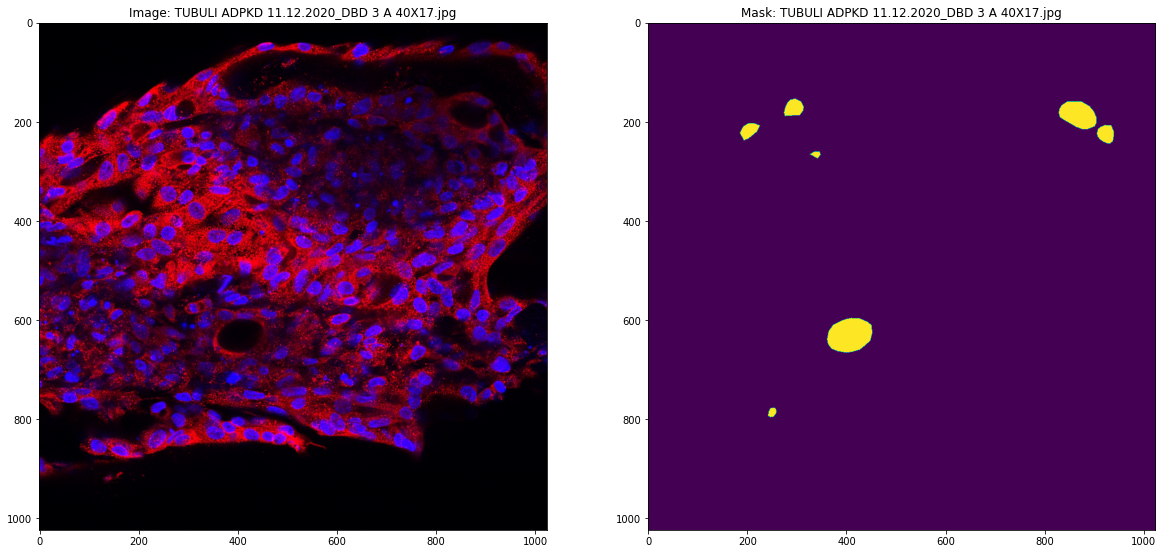

<IPython.core.display.Javascript object>

In [56]:
show_random(ALL_IMAGES, ALL_MASKS)

In [64]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self, images: List[Path], masks: List[Path] = None, transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        name = image_path.name
        image = utils.imread(image_path)

        result = {"image": image}

        if self.masks is not None:
            mask = imread(train_mask_path / f"{os.path.splitext(name)[0]}_mask.png")
            result["mask"] = mask

        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name

        return result

<IPython.core.display.Javascript object>

In [65]:
import albumentations as albu
from albumentations.pytorch import ToTensor
from PIL import Image


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
        albu.RandomRotate90(),
        albu.Cutout(),
        albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        albu.GridDistortion(p=0.3),
        albu.HueSaturationValue(p=0.3),
    ]

    return result


def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose(
        [
            albu.SmallestMaxSize(pre_size, p=1),
            albu.RandomCrop(image_size, image_size, p=1),
        ]
    )

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose(
        [
            albu.LongestMaxSize(pre_size, p=1),
            albu.RandomCrop(image_size, image_size, p=1),
        ]
    )

    # Converts the image to a square of size image_size x image_size
    result = [albu.OneOf([random_crop, rescale, random_crop_big], p=1)]

    return result


def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [ToTensor()]


def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose(
        [item for sublist in transforms_to_compose for item in sublist]
    )
    return result


def show_random_transform(transforms):
    transforms = compose([resize_transforms(), hard_transforms(), post_transforms()])
    length = len(ALL_IMAGES)
    index = random.randint(0, length - 1)
    IMG = ALL_IMAGES[index]
    
    plt.figure(figsize=(20, 28))
    plt.subplot(1, 2, 1)
    plt.imshow(utils.imread(IMG))
    plt.title(f"Image: {IMG}")
    
    transformed = transforms(image=utils.imread(IMG))
    transformed_image = transformed["image"]
    TRANSFORMED = np.moveaxis((np.array(transformed_image) * 255).astype("uint8"), 0, 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(TRANSFORMED))
    plt.title(f"Transformed")


<IPython.core.display.Javascript object>

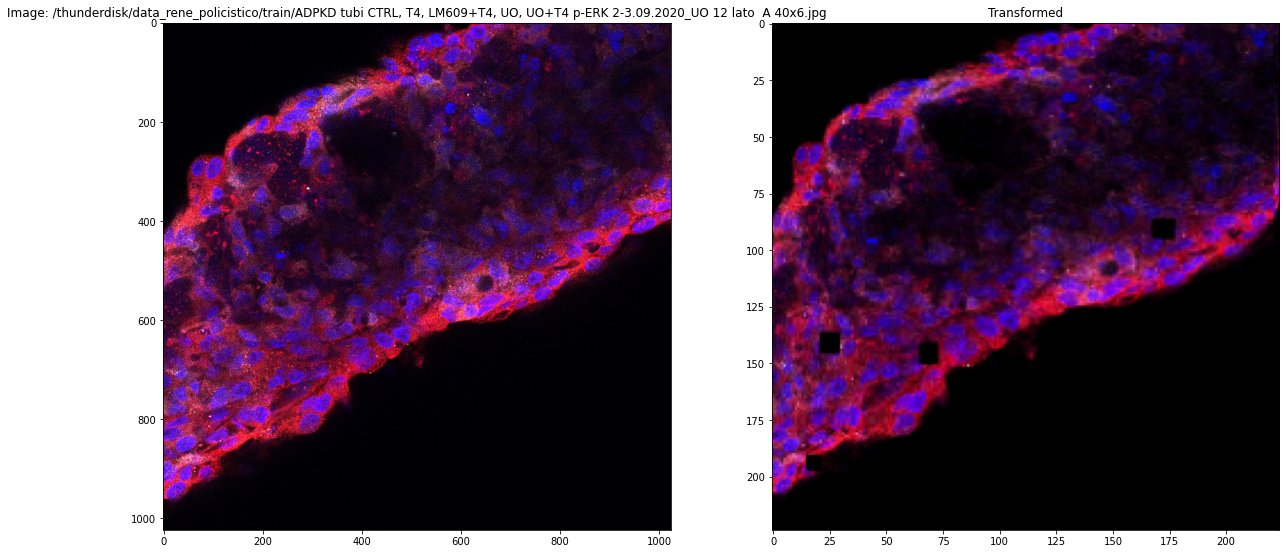

<IPython.core.display.Javascript object>

In [76]:
train_transforms = albu.Compose(
    [
        albu.RandomCrop(width=256, height=256),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.HueSaturationValue(p=0.5),
        ToTensor(),
    ]
)
train_transforms = compose([resize_transforms(), hard_transforms(), post_transforms()])

show_random_transform(train_transforms)

In [67]:
valid_transforms = compose([pre_transforms(), post_transforms()])

<IPython.core.display.Javascript object>

In [68]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader


def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn=None,
    valid_transforms_fn=None,
) -> dict:

    indices = np.arange(len(images))

    train_indices, valid_indices = train_test_split(
        indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    train_dataset = SegmentationDataset(
        images=np_images[train_indices].tolist(),
        masks=np_masks[train_indices].tolist(),
        transforms=train_transforms_fn,
    )

    valid_dataset = SegmentationDataset(
        images=np_images[valid_indices].tolist(),
        masks=np_masks[valid_indices].tolist(),
        transforms=valid_transforms_fn,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )

    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

<IPython.core.display.Javascript object>

In [69]:
batch_size = 32


print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
)

batch_size: 32


<IPython.core.display.Javascript object>

In [71]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

<IPython.core.display.Javascript object>

In [72]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

criterion = {"dice": DiceLoss(), "iou": IoULoss(), "bce": nn.BCEWithLogitsLoss()}

<IPython.core.display.Javascript object>

In [73]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.00001
encoder_learning_rate = 0.0005

layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

<IPython.core.display.Javascript object>

In [74]:
from catalyst.dl import SupervisedRunner

num_epochs = 100
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")


# by default SupervisedRunner uses "features" and "targets",
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


<IPython.core.display.Javascript object>

In [75]:
from catalyst.dl import (
    DiceCallback,
    IouCallback,
    CriterionCallback,
    MetricAggregationCallback,
)
from catalyst.contrib.callbacks import DrawMasksCallback

callbacks = [
    CriterionCallback(input_key="mask", prefix="loss_dice", criterion_key="dice"),
    CriterionCallback(input_key="mask", prefix="loss_iou", criterion_key="iou"),
    CriterionCallback(input_key="mask", prefix="loss_bce", criterion_key="bce"),
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",  # can be "sum", "weighted_sum" or "mean"
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # visualization
    DrawMasksCallback(
        output_key="logits",
        input_image_key="image",
        input_mask_key="mask",
        summary_step=50,
    ),
]

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)






1/100 * Epoch (train):   0% 0/9 [00:00<?, ?it/s]

/home/utente/anaconda3/envs/segmentation/lib/python3.7/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


1/100 * Epoch (train):   0% 0/10 [35:36<?, ?it/s]
1/100 * Epoch (train):   0% 0/10 [29:38<?, ?it/s]
1/100 * Epoch (train):   0% 0/10 [28:52<?, ?it/s]
1/100 * Epoch (train):   0% 0/9 [23:28<?, ?it/s]





1/100 * Epoch (train):   0% 0/9 [00:06<?, ?it/s, dice=0.011, iou=0.005, loss=2.481, loss_bce=0.622, loss_dice=0.989, loss_iou=0.995]




1/100 * Epoch (train):  11% 1/9 [00:06<00:51,  6.45s/it, dice=0.011, iou=0.005, loss=2.481, loss_bce=0.622, loss_dice=0.989, loss_iou=0.995]




1/100 * Epoch (train):  11% 1/9 [00:07<00:51,  6.45s/it, dice=0.012, iou=0.006, loss=2.478, loss_bce=0.619, loss_dice=0.988, loss_iou=0.994]




1/100 * Epoch (train):  22% 2/9 [00:07<00:32,  4.68s/it, dice=0.012, iou=0.006, loss=2.478, loss_bce=0.619, loss_dice=0.988, loss_iou=0.994]




1/100 * Epoch (train):  22% 2/9 [00:07<00:32,  4.68s/it, dice=0.013, iou=0.006, loss=2.475, loss_bce=0.618, loss_dice=0.987, loss_iou=0.994]




1/100 * Epoch (train):  33% 3/9 [00:07<00:20,  3.45s/it, dice=0.013, iou=0.006,

INFO:metrics_logger:
1/100 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.0132 | iou=0.0066 | loss=2.4731 | loss_bce=0.6161 | loss_dice=0.9868 | loss_iou=0.9934
1/100 * Epoch 1 (valid): dice=0.0082 | iou=0.0041 | loss=2.4340 | loss_bce=0.5579 | loss_dice=0.9918 | loss_iou=0.9959


2/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.011, iou=0.005, loss=2.466, loss_bce=0.603, loss_dice=0.989, loss_iou=0.995]
2/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.010, iou=0.005, loss=2.447, loss_bce=0.577, loss_dice=0.990, loss_iou=0.995]
[2020-12-22 15:35:26,405] 
2/100 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.0127 | iou=0.0064 | loss=2.4665 | loss_bce=0.6071 | loss_dice=0.9873 | loss_iou=0.9936
2/100 * Epoch 2 (valid): dice=0.0091 | iou=0.0046 | loss=2.4452 | loss_bce=0.5735 | loss_dice=0.9909 | loss_iou=0.9954


INFO:metrics_logger:
2/100 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.0127 | iou=0.0064 | loss=2.4665 | loss_bce=0.6071 | loss_dice=0.9873 | loss_iou=0.9936
2/100 * Epoch 2 (valid): dice=0.0091 | iou=0.0046 | loss=2.4452 | loss_bce=0.5735 | loss_dice=0.9909 | loss_iou=0.9954


3/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.37it/s, dice=0.016, iou=0.008, loss=2.448, loss_bce=0.591, loss_dice=0.984, loss_iou=0.992]
3/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.010, iou=0.005, loss=2.480, loss_bce=0.619, loss_dice=0.990, loss_iou=0.995]
[2020-12-22 15:36:10,345] 
3/100 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/100 * Epoch 3 (train): dice=0.0143 | iou=0.0072 | loss=2.4534 | loss_bce=0.5935 | loss_dice=0.9857 | loss_iou=0.9928
3/100 * Epoch 3 (valid): dice=0.0093 | iou=0.0047 | loss=2.4798 | loss_bce=0.6173 | loss_dice=0.9907 | loss_iou=0.9953


INFO:metrics_logger:
3/100 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/100 * Epoch 3 (train): dice=0.0143 | iou=0.0072 | loss=2.4534 | loss_bce=0.5935 | loss_dice=0.9857 | loss_iou=0.9928
3/100 * Epoch 3 (valid): dice=0.0093 | iou=0.0047 | loss=2.4798 | loss_bce=0.6173 | loss_dice=0.9907 | loss_iou=0.9953


4/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.45it/s, dice=0.014, iou=0.007, loss=2.426, loss_bce=0.559, loss_dice=0.986, loss_iou=0.993]
4/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.17it/s, dice=0.011, iou=0.006, loss=2.490, loss_bce=0.633, loss_dice=0.989, loss_iou=0.994]
[2020-12-22 15:36:49,752] 
4/100 * Epoch 4 (_base): lr=0.0001 | momentum=0.9000
4/100 * Epoch 4 (train): dice=0.0143 | iou=0.0072 | loss=2.4380 | loss_bce=0.5745 | loss_dice=0.9857 | loss_iou=0.9928
4/100 * Epoch 4 (valid): dice=0.0100 | iou=0.0050 | loss=2.4936 | loss_bce=0.6357 | loss_dice=0.9900 | loss_iou=0.9950


INFO:metrics_logger:
4/100 * Epoch 4 (_base): lr=0.0001 | momentum=0.9000
4/100 * Epoch 4 (train): dice=0.0143 | iou=0.0072 | loss=2.4380 | loss_bce=0.5745 | loss_dice=0.9857 | loss_iou=0.9928
4/100 * Epoch 4 (valid): dice=0.0100 | iou=0.0050 | loss=2.4936 | loss_bce=0.6357 | loss_dice=0.9900 | loss_iou=0.9950


5/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.45it/s, dice=0.015, iou=0.008, loss=2.423, loss_bce=0.557, loss_dice=0.985, loss_iou=0.992]
5/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.476, loss_bce=0.618, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:37:20,332] 
5/100 * Epoch 5 (_base): lr=0.0001 | momentum=0.9000
5/100 * Epoch 5 (train): dice=0.0151 | iou=0.0076 | loss=2.4273 | loss_bce=0.5625 | loss_dice=0.9849 | loss_iou=0.9924
5/100 * Epoch 5 (valid): dice=0.0108 | iou=0.0055 | loss=2.4771 | loss_bce=0.6167 | loss_dice=0.9892 | loss_iou=0.9945


INFO:metrics_logger:
5/100 * Epoch 5 (_base): lr=0.0001 | momentum=0.9000
5/100 * Epoch 5 (train): dice=0.0151 | iou=0.0076 | loss=2.4273 | loss_bce=0.5625 | loss_dice=0.9849 | loss_iou=0.9924
5/100 * Epoch 5 (valid): dice=0.0108 | iou=0.0055 | loss=2.4771 | loss_bce=0.6167 | loss_dice=0.9892 | loss_iou=0.9945


6/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.010, iou=0.005, loss=2.423, loss_bce=0.548, loss_dice=0.990, loss_iou=0.995]
6/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.013, iou=0.006, loss=2.449, loss_bce=0.585, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:38:01,322] 
6/100 * Epoch 6 (_base): lr=0.0001 | momentum=0.9000
6/100 * Epoch 6 (train): dice=0.0156 | iou=0.0079 | loss=2.4195 | loss_bce=0.5538 | loss_dice=0.9844 | loss_iou=0.9921
6/100 * Epoch 6 (valid): dice=0.0110 | iou=0.0055 | loss=2.4456 | loss_bce=0.5777 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
6/100 * Epoch 6 (_base): lr=0.0001 | momentum=0.9000
6/100 * Epoch 6 (train): dice=0.0156 | iou=0.0079 | loss=2.4195 | loss_bce=0.5538 | loss_dice=0.9844 | loss_iou=0.9921
6/100 * Epoch 6 (valid): dice=0.0110 | iou=0.0055 | loss=2.4456 | loss_bce=0.5777 | loss_dice=0.9890 | loss_iou=0.9945


7/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.46it/s, dice=0.016, iou=0.008, loss=2.404, loss_bce=0.536, loss_dice=0.984, loss_iou=0.992]
7/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.21it/s, dice=0.013, iou=0.006, loss=2.424, loss_bce=0.554, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:38:31,132] 
7/100 * Epoch 7 (_base): lr=3.125e-05 | momentum=0.9000
7/100 * Epoch 7 (train): dice=0.0166 | iou=0.0084 | loss=2.4081 | loss_bce=0.5414 | loss_dice=0.9834 | loss_iou=0.9916
7/100 * Epoch 7 (valid): dice=0.0110 | iou=0.0056 | loss=2.4185 | loss_bce=0.5439 | loss_dice=0.9890 | loss_iou=0.9944


INFO:metrics_logger:
7/100 * Epoch 7 (_base): lr=3.125e-05 | momentum=0.9000
7/100 * Epoch 7 (train): dice=0.0166 | iou=0.0084 | loss=2.4081 | loss_bce=0.5414 | loss_dice=0.9834 | loss_iou=0.9916
7/100 * Epoch 7 (valid): dice=0.0110 | iou=0.0056 | loss=2.4185 | loss_bce=0.5439 | loss_dice=0.9890 | loss_iou=0.9944


8/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.36it/s, dice=0.021, iou=0.011, loss=2.396, loss_bce=0.535, loss_dice=0.979, loss_iou=0.989]
8/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.402, loss_bce=0.526, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:39:09,781] 
8/100 * Epoch 8 (_base): lr=3.125e-05 | momentum=0.9000
8/100 * Epoch 8 (train): dice=0.0156 | iou=0.0079 | loss=2.4052 | loss_bce=0.5358 | loss_dice=0.9844 | loss_iou=0.9921
8/100 * Epoch 8 (valid): dice=0.0106 | iou=0.0053 | loss=2.3993 | loss_bce=0.5191 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
8/100 * Epoch 8 (_base): lr=3.125e-05 | momentum=0.9000
8/100 * Epoch 8 (train): dice=0.0156 | iou=0.0079 | loss=2.4052 | loss_bce=0.5358 | loss_dice=0.9844 | loss_iou=0.9921
8/100 * Epoch 8 (valid): dice=0.0106 | iou=0.0053 | loss=2.3993 | loss_bce=0.5191 | loss_dice=0.9894 | loss_iou=0.9947


9/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.019, iou=0.010, loss=2.395, loss_bce=0.529, loss_dice=0.981, loss_iou=0.990]
9/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.403, loss_bce=0.528, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:39:30,901] 
9/100 * Epoch 9 (_base): lr=3.125e-05 | momentum=0.9000
9/100 * Epoch 9 (train): dice=0.0173 | iou=0.0087 | loss=2.3996 | loss_bce=0.5321 | loss_dice=0.9827 | loss_iou=0.9913
9/100 * Epoch 9 (valid): dice=0.0108 | iou=0.0054 | loss=2.3983 | loss_bce=0.5182 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
9/100 * Epoch 9 (_base): lr=3.125e-05 | momentum=0.9000
9/100 * Epoch 9 (train): dice=0.0173 | iou=0.0087 | loss=2.3996 | loss_bce=0.5321 | loss_dice=0.9827 | loss_iou=0.9913
9/100 * Epoch 9 (valid): dice=0.0108 | iou=0.0054 | loss=2.3983 | loss_bce=0.5182 | loss_dice=0.9892 | loss_iou=0.9946


10/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.33it/s, dice=0.015, iou=0.008, loss=2.400, loss_bce=0.528, loss_dice=0.985, loss_iou=0.992]
10/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.402, loss_bce=0.525, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:39:52,329] 
10/100 * Epoch 10 (_base): lr=7.813e-06 | momentum=0.9000
10/100 * Epoch 10 (train): dice=0.0157 | iou=0.0079 | loss=2.3996 | loss_bce=0.5290 | loss_dice=0.9843 | loss_iou=0.9921
10/100 * Epoch 10 (valid): dice=0.0107 | iou=0.0054 | loss=2.3963 | loss_bce=0.5155 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
10/100 * Epoch 10 (_base): lr=7.813e-06 | momentum=0.9000
10/100 * Epoch 10 (train): dice=0.0157 | iou=0.0079 | loss=2.3996 | loss_bce=0.5290 | loss_dice=0.9843 | loss_iou=0.9921
10/100 * Epoch 10 (valid): dice=0.0107 | iou=0.0054 | loss=2.3963 | loss_bce=0.5155 | loss_dice=0.9893 | loss_iou=0.9946


11/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.36it/s, dice=0.017, iou=0.008, loss=2.397, loss_bce=0.528, loss_dice=0.983, loss_iou=0.992]
11/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.520, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:40:18,495] 
11/100 * Epoch 11 (_base): lr=7.813e-06 | momentum=0.9000
11/100 * Epoch 11 (train): dice=0.0165 | iou=0.0083 | loss=2.3962 | loss_bce=0.5264 | loss_dice=0.9835 | loss_iou=0.9917
11/100 * Epoch 11 (valid): dice=0.0107 | iou=0.0054 | loss=2.3941 | loss_bce=0.5128 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
11/100 * Epoch 11 (_base): lr=7.813e-06 | momentum=0.9000
11/100 * Epoch 11 (train): dice=0.0165 | iou=0.0083 | loss=2.3962 | loss_bce=0.5264 | loss_dice=0.9835 | loss_iou=0.9917
11/100 * Epoch 11 (valid): dice=0.0107 | iou=0.0054 | loss=2.3941 | loss_bce=0.5128 | loss_dice=0.9893 | loss_iou=0.9946


12/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.011, iou=0.006, loss=2.405, loss_bce=0.527, loss_dice=0.989, loss_iou=0.994]
12/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.013, iou=0.006, loss=2.399, loss_bce=0.523, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:40:39,364] 
12/100 * Epoch 12 (_base): lr=7.813e-06 | momentum=0.9000
12/100 * Epoch 12 (train): dice=0.0174 | iou=0.0088 | loss=2.3951 | loss_bce=0.5266 | loss_dice=0.9826 | loss_iou=0.9912
12/100 * Epoch 12 (valid): dice=0.0110 | iou=0.0055 | loss=2.3956 | loss_bce=0.5151 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
12/100 * Epoch 12 (_base): lr=7.813e-06 | momentum=0.9000
12/100 * Epoch 12 (train): dice=0.0174 | iou=0.0088 | loss=2.3951 | loss_bce=0.5266 | loss_dice=0.9826 | loss_iou=0.9912
12/100 * Epoch 12 (valid): dice=0.0110 | iou=0.0055 | loss=2.3956 | loss_bce=0.5151 | loss_dice=0.9890 | loss_iou=0.9945


13/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.35it/s, dice=0.023, iou=0.012, loss=2.381, loss_bce=0.521, loss_dice=0.977, loss_iou=0.988]
13/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:41:01,161] 
13/100 * Epoch 13 (_base): lr=1.953e-06 | momentum=0.9000
13/100 * Epoch 13 (train): dice=0.0163 | iou=0.0082 | loss=2.3960 | loss_bce=0.5256 | loss_dice=0.9837 | loss_iou=0.9918
13/100 * Epoch 13 (valid): dice=0.0105 | iou=0.0053 | loss=2.3878 | loss_bce=0.5045 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
13/100 * Epoch 13 (_base): lr=1.953e-06 | momentum=0.9000
13/100 * Epoch 13 (train): dice=0.0163 | iou=0.0082 | loss=2.3960 | loss_bce=0.5256 | loss_dice=0.9837 | loss_iou=0.9918
13/100 * Epoch 13 (valid): dice=0.0105 | iou=0.0053 | loss=2.3878 | loss_bce=0.5045 | loss_dice=0.9895 | loss_iou=0.9947


14/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.012, iou=0.006, loss=2.405, loss_bce=0.528, loss_dice=0.988, loss_iou=0.994]
14/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.399, loss_bce=0.523, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:41:20,579] 
14/100 * Epoch 14 (_base): lr=1.953e-06 | momentum=0.9000
14/100 * Epoch 14 (train): dice=0.0168 | iou=0.0085 | loss=2.3953 | loss_bce=0.5256 | loss_dice=0.9832 | loss_iou=0.9915
14/100 * Epoch 14 (valid): dice=0.0109 | iou=0.0055 | loss=2.3942 | loss_bce=0.5132 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
14/100 * Epoch 14 (_base): lr=1.953e-06 | momentum=0.9000
14/100 * Epoch 14 (train): dice=0.0168 | iou=0.0085 | loss=2.3953 | loss_bce=0.5256 | loss_dice=0.9832 | loss_iou=0.9915
14/100 * Epoch 14 (valid): dice=0.0109 | iou=0.0055 | loss=2.3942 | loss_bce=0.5132 | loss_dice=0.9891 | loss_iou=0.9945


15/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.35it/s, dice=0.018, iou=0.009, loss=2.392, loss_bce=0.525, loss_dice=0.982, loss_iou=0.991]
15/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.397, loss_bce=0.519, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:41:47,123] 
15/100 * Epoch 15 (_base): lr=1.953e-06 | momentum=0.9000
15/100 * Epoch 15 (train): dice=0.0168 | iou=0.0085 | loss=2.3945 | loss_bce=0.5247 | loss_dice=0.9832 | loss_iou=0.9915
15/100 * Epoch 15 (valid): dice=0.0107 | iou=0.0054 | loss=2.3914 | loss_bce=0.5094 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
15/100 * Epoch 15 (_base): lr=1.953e-06 | momentum=0.9000
15/100 * Epoch 15 (train): dice=0.0168 | iou=0.0085 | loss=2.3945 | loss_bce=0.5247 | loss_dice=0.9832 | loss_iou=0.9915
15/100 * Epoch 15 (valid): dice=0.0107 | iou=0.0054 | loss=2.3914 | loss_bce=0.5094 | loss_dice=0.9893 | loss_iou=0.9946


16/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.013, iou=0.006, loss=2.401, loss_bce=0.526, loss_dice=0.987, loss_iou=0.994]
16/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.401, loss_bce=0.525, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:42:06,542] 
16/100 * Epoch 16 (_base): lr=4.883e-07 | momentum=0.9000
16/100 * Epoch 16 (train): dice=0.0175 | iou=0.0088 | loss=2.3935 | loss_bce=0.5248 | loss_dice=0.9825 | loss_iou=0.9912
16/100 * Epoch 16 (valid): dice=0.0108 | iou=0.0054 | loss=2.3955 | loss_bce=0.5148 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
16/100 * Epoch 16 (_base): lr=4.883e-07 | momentum=0.9000
16/100 * Epoch 16 (train): dice=0.0175 | iou=0.0088 | loss=2.3935 | loss_bce=0.5248 | loss_dice=0.9825 | loss_iou=0.9912
16/100 * Epoch 16 (valid): dice=0.0108 | iou=0.0054 | loss=2.3955 | loss_bce=0.5148 | loss_dice=0.9892 | loss_iou=0.9946


17/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.019, iou=0.010, loss=2.390, loss_bce=0.524, loss_dice=0.981, loss_iou=0.990]
17/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.396, loss_bce=0.519, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:42:32,196] 
17/100 * Epoch 17 (_base): lr=4.883e-07 | momentum=0.9000
17/100 * Epoch 17 (train): dice=0.0171 | iou=0.0086 | loss=2.3942 | loss_bce=0.5248 | loss_dice=0.9829 | loss_iou=0.9914
17/100 * Epoch 17 (valid): dice=0.0108 | iou=0.0054 | loss=2.3913 | loss_bce=0.5094 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
17/100 * Epoch 17 (_base): lr=4.883e-07 | momentum=0.9000
17/100 * Epoch 17 (train): dice=0.0171 | iou=0.0086 | loss=2.3942 | loss_bce=0.5248 | loss_dice=0.9829 | loss_iou=0.9914
17/100 * Epoch 17 (valid): dice=0.0108 | iou=0.0054 | loss=2.3913 | loss_bce=0.5094 | loss_dice=0.9892 | loss_iou=0.9946


18/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.45it/s, dice=0.013, iou=0.007, loss=2.401, loss_bce=0.525, loss_dice=0.987, loss_iou=0.993]
18/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.29it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.520, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:42:51,957] 
18/100 * Epoch 18 (_base): lr=4.883e-07 | momentum=0.9000
18/100 * Epoch 18 (train): dice=0.0171 | iou=0.0087 | loss=2.3944 | loss_bce=0.5252 | loss_dice=0.9829 | loss_iou=0.9913
18/100 * Epoch 18 (valid): dice=0.0108 | iou=0.0054 | loss=2.3924 | loss_bce=0.5108 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
18/100 * Epoch 18 (_base): lr=4.883e-07 | momentum=0.9000
18/100 * Epoch 18 (train): dice=0.0171 | iou=0.0087 | loss=2.3944 | loss_bce=0.5252 | loss_dice=0.9829 | loss_iou=0.9913
18/100 * Epoch 18 (valid): dice=0.0108 | iou=0.0054 | loss=2.3924 | loss_bce=0.5108 | loss_dice=0.9892 | loss_iou=0.9946


19/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.015, iou=0.008, loss=2.396, loss_bce=0.523, loss_dice=0.985, loss_iou=0.992]
19/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.516, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:43:17,537] 
19/100 * Epoch 19 (_base): lr=1.221e-07 | momentum=0.9000
19/100 * Epoch 19 (train): dice=0.0173 | iou=0.0087 | loss=2.3943 | loss_bce=0.5254 | loss_dice=0.9827 | loss_iou=0.9913
19/100 * Epoch 19 (valid): dice=0.0108 | iou=0.0054 | loss=2.3891 | loss_bce=0.5067 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
19/100 * Epoch 19 (_base): lr=1.221e-07 | momentum=0.9000
19/100 * Epoch 19 (train): dice=0.0173 | iou=0.0087 | loss=2.3943 | loss_bce=0.5254 | loss_dice=0.9827 | loss_iou=0.9913
19/100 * Epoch 19 (valid): dice=0.0108 | iou=0.0054 | loss=2.3891 | loss_bce=0.5067 | loss_dice=0.9892 | loss_iou=0.9946


20/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.017, iou=0.009, loss=2.396, loss_bce=0.528, loss_dice=0.983, loss_iou=0.991]
20/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.29it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.511, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:43:37,203] 
20/100 * Epoch 20 (_base): lr=1.221e-07 | momentum=0.9000
20/100 * Epoch 20 (train): dice=0.0169 | iou=0.0085 | loss=2.3940 | loss_bce=0.5244 | loss_dice=0.9831 | loss_iou=0.9915
20/100 * Epoch 20 (valid): dice=0.0107 | iou=0.0054 | loss=2.3866 | loss_bce=0.5033 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
20/100 * Epoch 20 (_base): lr=1.221e-07 | momentum=0.9000
20/100 * Epoch 20 (train): dice=0.0169 | iou=0.0085 | loss=2.3940 | loss_bce=0.5244 | loss_dice=0.9831 | loss_iou=0.9915
20/100 * Epoch 20 (valid): dice=0.0107 | iou=0.0054 | loss=2.3866 | loss_bce=0.5033 | loss_dice=0.9893 | loss_iou=0.9946


21/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.018, iou=0.009, loss=2.392, loss_bce=0.524, loss_dice=0.982, loss_iou=0.991]
21/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.30it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:44:02,660] 
21/100 * Epoch 21 (_base): lr=1.221e-07 | momentum=0.9000
21/100 * Epoch 21 (train): dice=0.0176 | iou=0.0089 | loss=2.3933 | loss_bce=0.5246 | loss_dice=0.9824 | loss_iou=0.9911
21/100 * Epoch 21 (valid): dice=0.0106 | iou=0.0053 | loss=2.3914 | loss_bce=0.5092 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
21/100 * Epoch 21 (_base): lr=1.221e-07 | momentum=0.9000
21/100 * Epoch 21 (train): dice=0.0176 | iou=0.0089 | loss=2.3933 | loss_bce=0.5246 | loss_dice=0.9824 | loss_iou=0.9911
21/100 * Epoch 21 (valid): dice=0.0106 | iou=0.0053 | loss=2.3914 | loss_bce=0.5092 | loss_dice=0.9894 | loss_iou=0.9947


22/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.44it/s, dice=0.014, iou=0.007, loss=2.399, loss_bce=0.525, loss_dice=0.986, loss_iou=0.993]
22/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.521, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:44:22,793] 
22/100 * Epoch 22 (_base): lr=3.052e-08 | momentum=0.9000
22/100 * Epoch 22 (train): dice=0.0172 | iou=0.0087 | loss=2.3933 | loss_bce=0.5240 | loss_dice=0.9828 | loss_iou=0.9913
22/100 * Epoch 22 (valid): dice=0.0107 | iou=0.0054 | loss=2.3931 | loss_bce=0.5116 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
22/100 * Epoch 22 (_base): lr=3.052e-08 | momentum=0.9000
22/100 * Epoch 22 (train): dice=0.0172 | iou=0.0087 | loss=2.3933 | loss_bce=0.5240 | loss_dice=0.9828 | loss_iou=0.9913
22/100 * Epoch 22 (valid): dice=0.0107 | iou=0.0054 | loss=2.3931 | loss_bce=0.5116 | loss_dice=0.9893 | loss_iou=0.9946


23/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.023, iou=0.012, loss=2.382, loss_bce=0.522, loss_dice=0.977, loss_iou=0.988]
23/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:44:47,636] 
23/100 * Epoch 23 (_base): lr=3.052e-08 | momentum=0.9000
23/100 * Epoch 23 (train): dice=0.0177 | iou=0.0089 | loss=2.3922 | loss_bce=0.5235 | loss_dice=0.9823 | loss_iou=0.9911
23/100 * Epoch 23 (valid): dice=0.0107 | iou=0.0054 | loss=2.3905 | loss_bce=0.5082 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
23/100 * Epoch 23 (_base): lr=3.052e-08 | momentum=0.9000
23/100 * Epoch 23 (train): dice=0.0177 | iou=0.0089 | loss=2.3922 | loss_bce=0.5235 | loss_dice=0.9823 | loss_iou=0.9911
23/100 * Epoch 23 (valid): dice=0.0107 | iou=0.0054 | loss=2.3905 | loss_bce=0.5082 | loss_dice=0.9893 | loss_iou=0.9946


24/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.016, iou=0.008, loss=2.395, loss_bce=0.524, loss_dice=0.984, loss_iou=0.992]
24/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.399, loss_bce=0.522, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:45:07,022] 
24/100 * Epoch 24 (_base): lr=3.052e-08 | momentum=0.9000
24/100 * Epoch 24 (train): dice=0.0176 | iou=0.0089 | loss=2.3927 | loss_bce=0.5239 | loss_dice=0.9824 | loss_iou=0.9911
24/100 * Epoch 24 (valid): dice=0.0109 | iou=0.0055 | loss=2.3920 | loss_bce=0.5105 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
24/100 * Epoch 24 (_base): lr=3.052e-08 | momentum=0.9000
24/100 * Epoch 24 (train): dice=0.0176 | iou=0.0089 | loss=2.3927 | loss_bce=0.5239 | loss_dice=0.9824 | loss_iou=0.9911
24/100 * Epoch 24 (valid): dice=0.0109 | iou=0.0055 | loss=2.3920 | loss_bce=0.5105 | loss_dice=0.9891 | loss_iou=0.9945


25/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.017, iou=0.009, loss=2.394, loss_bce=0.526, loss_dice=0.983, loss_iou=0.991]
25/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.389, loss_bce=0.509, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:45:31,522] 
25/100 * Epoch 25 (_base): lr=7.629e-09 | momentum=0.9000
25/100 * Epoch 25 (train): dice=0.0164 | iou=0.0083 | loss=2.3955 | loss_bce=0.5252 | loss_dice=0.9836 | loss_iou=0.9917
25/100 * Epoch 25 (valid): dice=0.0106 | iou=0.0053 | loss=2.3852 | loss_bce=0.5014 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
25/100 * Epoch 25 (_base): lr=7.629e-09 | momentum=0.9000
25/100 * Epoch 25 (train): dice=0.0164 | iou=0.0083 | loss=2.3955 | loss_bce=0.5252 | loss_dice=0.9836 | loss_iou=0.9917
25/100 * Epoch 25 (valid): dice=0.0106 | iou=0.0053 | loss=2.3852 | loss_bce=0.5014 | loss_dice=0.9894 | loss_iou=0.9947


26/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.018, iou=0.009, loss=2.394, loss_bce=0.525, loss_dice=0.982, loss_iou=0.991]
26/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:45:51,405] 
26/100 * Epoch 26 (_base): lr=7.629e-09 | momentum=0.9000
26/100 * Epoch 26 (train): dice=0.0169 | iou=0.0085 | loss=2.3947 | loss_bce=0.5250 | loss_dice=0.9831 | loss_iou=0.9915
26/100 * Epoch 26 (valid): dice=0.0106 | iou=0.0053 | loss=2.3902 | loss_bce=0.5077 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
26/100 * Epoch 26 (_base): lr=7.629e-09 | momentum=0.9000
26/100 * Epoch 26 (train): dice=0.0169 | iou=0.0085 | loss=2.3947 | loss_bce=0.5250 | loss_dice=0.9831 | loss_iou=0.9915
26/100 * Epoch 26 (valid): dice=0.0106 | iou=0.0053 | loss=2.3902 | loss_bce=0.5077 | loss_dice=0.9894 | loss_iou=0.9947


27/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.34it/s, dice=0.018, iou=0.009, loss=2.395, loss_bce=0.527, loss_dice=0.982, loss_iou=0.991]
27/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.511, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:46:16,999] 
27/100 * Epoch 27 (_base): lr=7.629e-09 | momentum=0.9000
27/100 * Epoch 27 (train): dice=0.0164 | iou=0.0083 | loss=2.3953 | loss_bce=0.5250 | loss_dice=0.9836 | loss_iou=0.9917
27/100 * Epoch 27 (valid): dice=0.0107 | iou=0.0054 | loss=2.3860 | loss_bce=0.5027 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
27/100 * Epoch 27 (_base): lr=7.629e-09 | momentum=0.9000
27/100 * Epoch 27 (train): dice=0.0164 | iou=0.0083 | loss=2.3953 | loss_bce=0.5250 | loss_dice=0.9836 | loss_iou=0.9917
27/100 * Epoch 27 (valid): dice=0.0107 | iou=0.0054 | loss=2.3860 | loss_bce=0.5027 | loss_dice=0.9893 | loss_iou=0.9946


28/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.018, iou=0.009, loss=2.392, loss_bce=0.524, loss_dice=0.982, loss_iou=0.991]
28/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.510, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:46:36,714] 
28/100 * Epoch 28 (_base): lr=7.629e-09 | momentum=0.9000
28/100 * Epoch 28 (train): dice=0.0174 | iou=0.0088 | loss=2.3937 | loss_bce=0.5248 | loss_dice=0.9826 | loss_iou=0.9912
28/100 * Epoch 28 (valid): dice=0.0107 | iou=0.0054 | loss=2.3865 | loss_bce=0.5032 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
28/100 * Epoch 28 (_base): lr=7.629e-09 | momentum=0.9000
28/100 * Epoch 28 (train): dice=0.0174 | iou=0.0088 | loss=2.3937 | loss_bce=0.5248 | loss_dice=0.9826 | loss_iou=0.9912
28/100 * Epoch 28 (valid): dice=0.0107 | iou=0.0054 | loss=2.3865 | loss_bce=0.5032 | loss_dice=0.9893 | loss_iou=0.9946


29/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.020, iou=0.010, loss=2.392, loss_bce=0.528, loss_dice=0.980, loss_iou=0.990]
29/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:46:58,566] 
29/100 * Epoch 29 (_base): lr=7.629e-09 | momentum=0.9000
29/100 * Epoch 29 (train): dice=0.0177 | iou=0.0089 | loss=2.3938 | loss_bce=0.5255 | loss_dice=0.9823 | loss_iou=0.9911
29/100 * Epoch 29 (valid): dice=0.0106 | iou=0.0054 | loss=2.3883 | loss_bce=0.5053 | loss_dice=0.9894 | loss_iou=0.9946


INFO:metrics_logger:
29/100 * Epoch 29 (_base): lr=7.629e-09 | momentum=0.9000
29/100 * Epoch 29 (train): dice=0.0177 | iou=0.0089 | loss=2.3938 | loss_bce=0.5255 | loss_dice=0.9823 | loss_iou=0.9911
29/100 * Epoch 29 (valid): dice=0.0106 | iou=0.0054 | loss=2.3883 | loss_bce=0.5053 | loss_dice=0.9894 | loss_iou=0.9946


30/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.015, iou=0.008, loss=2.398, loss_bce=0.526, loss_dice=0.985, loss_iou=0.992]
30/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.397, loss_bce=0.520, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:47:24,112] 
30/100 * Epoch 30 (_base): lr=7.629e-09 | momentum=0.9000
30/100 * Epoch 30 (train): dice=0.0175 | iou=0.0088 | loss=2.3943 | loss_bce=0.5258 | loss_dice=0.9825 | loss_iou=0.9912
30/100 * Epoch 30 (valid): dice=0.0108 | iou=0.0054 | loss=2.3917 | loss_bce=0.5100 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
30/100 * Epoch 30 (_base): lr=7.629e-09 | momentum=0.9000
30/100 * Epoch 30 (train): dice=0.0175 | iou=0.0088 | loss=2.3943 | loss_bce=0.5258 | loss_dice=0.9825 | loss_iou=0.9912
30/100 * Epoch 30 (valid): dice=0.0108 | iou=0.0054 | loss=2.3917 | loss_bce=0.5100 | loss_dice=0.9892 | loss_iou=0.9946


31/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.016, iou=0.008, loss=2.397, loss_bce=0.526, loss_dice=0.984, loss_iou=0.992]
31/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.399, loss_bce=0.523, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:47:43,118] 
31/100 * Epoch 31 (_base): lr=7.629e-09 | momentum=0.9000
31/100 * Epoch 31 (train): dice=0.0172 | iou=0.0087 | loss=2.3946 | loss_bce=0.5255 | loss_dice=0.9828 | loss_iou=0.9913
31/100 * Epoch 31 (valid): dice=0.0108 | iou=0.0054 | loss=2.3937 | loss_bce=0.5124 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
31/100 * Epoch 31 (_base): lr=7.629e-09 | momentum=0.9000
31/100 * Epoch 31 (train): dice=0.0172 | iou=0.0087 | loss=2.3946 | loss_bce=0.5255 | loss_dice=0.9828 | loss_iou=0.9913
31/100 * Epoch 31 (valid): dice=0.0108 | iou=0.0054 | loss=2.3937 | loss_bce=0.5124 | loss_dice=0.9892 | loss_iou=0.9946


32/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.016, iou=0.008, loss=2.396, loss_bce=0.525, loss_dice=0.984, loss_iou=0.992]
32/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:48:08,542] 
32/100 * Epoch 32 (_base): lr=7.629e-09 | momentum=0.9000
32/100 * Epoch 32 (train): dice=0.0173 | iou=0.0087 | loss=2.3939 | loss_bce=0.5249 | loss_dice=0.9827 | loss_iou=0.9913
32/100 * Epoch 32 (valid): dice=0.0106 | iou=0.0053 | loss=2.3881 | loss_bce=0.5050 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
32/100 * Epoch 32 (_base): lr=7.629e-09 | momentum=0.9000
32/100 * Epoch 32 (train): dice=0.0173 | iou=0.0087 | loss=2.3939 | loss_bce=0.5249 | loss_dice=0.9827 | loss_iou=0.9913
32/100 * Epoch 32 (valid): dice=0.0106 | iou=0.0053 | loss=2.3881 | loss_bce=0.5050 | loss_dice=0.9894 | loss_iou=0.9947


33/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.013, iou=0.007, loss=2.405, loss_bce=0.530, loss_dice=0.987, loss_iou=0.993]
33/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.22it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:48:28,637] 
33/100 * Epoch 33 (_base): lr=7.629e-09 | momentum=0.9000
33/100 * Epoch 33 (train): dice=0.0171 | iou=0.0086 | loss=2.3952 | loss_bce=0.5262 | loss_dice=0.9829 | loss_iou=0.9914
33/100 * Epoch 33 (valid): dice=0.0108 | iou=0.0054 | loss=2.3894 | loss_bce=0.5070 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
33/100 * Epoch 33 (_base): lr=7.629e-09 | momentum=0.9000
33/100 * Epoch 33 (train): dice=0.0171 | iou=0.0086 | loss=2.3952 | loss_bce=0.5262 | loss_dice=0.9829 | loss_iou=0.9914
33/100 * Epoch 33 (valid): dice=0.0108 | iou=0.0054 | loss=2.3894 | loss_bce=0.5070 | loss_dice=0.9892 | loss_iou=0.9946


34/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.34it/s, dice=0.013, iou=0.007, loss=2.402, loss_bce=0.527, loss_dice=0.987, loss_iou=0.993]
34/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.013, iou=0.006, loss=2.401, loss_bce=0.524, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:48:54,208] 
34/100 * Epoch 34 (_base): lr=7.629e-09 | momentum=0.9000
34/100 * Epoch 34 (train): dice=0.0155 | iou=0.0078 | loss=2.3973 | loss_bce=0.5257 | loss_dice=0.9845 | loss_iou=0.9922
34/100 * Epoch 34 (valid): dice=0.0110 | iou=0.0055 | loss=2.3937 | loss_bce=0.5128 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
34/100 * Epoch 34 (_base): lr=7.629e-09 | momentum=0.9000
34/100 * Epoch 34 (train): dice=0.0155 | iou=0.0078 | loss=2.3973 | loss_bce=0.5257 | loss_dice=0.9845 | loss_iou=0.9922
34/100 * Epoch 34 (valid): dice=0.0110 | iou=0.0055 | loss=2.3937 | loss_bce=0.5128 | loss_dice=0.9890 | loss_iou=0.9945


35/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.37it/s, dice=0.015, iou=0.007, loss=2.396, loss_bce=0.523, loss_dice=0.985, loss_iou=0.993]
35/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.21it/s, dice=0.012, iou=0.006, loss=2.397, loss_bce=0.519, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:49:14,110] 
35/100 * Epoch 35 (_base): lr=7.629e-09 | momentum=0.9000
35/100 * Epoch 35 (train): dice=0.0163 | iou=0.0082 | loss=2.3956 | loss_bce=0.5252 | loss_dice=0.9837 | loss_iou=0.9918
35/100 * Epoch 35 (valid): dice=0.0109 | iou=0.0055 | loss=2.3911 | loss_bce=0.5092 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
35/100 * Epoch 35 (_base): lr=7.629e-09 | momentum=0.9000
35/100 * Epoch 35 (train): dice=0.0163 | iou=0.0082 | loss=2.3956 | loss_bce=0.5252 | loss_dice=0.9837 | loss_iou=0.9918
35/100 * Epoch 35 (valid): dice=0.0109 | iou=0.0055 | loss=2.3911 | loss_bce=0.5092 | loss_dice=0.9891 | loss_iou=0.9945


36/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.018, iou=0.009, loss=2.392, loss_bce=0.524, loss_dice=0.982, loss_iou=0.991]
36/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:49:35,813] 
36/100 * Epoch 36 (_base): lr=7.629e-09 | momentum=0.9000
36/100 * Epoch 36 (train): dice=0.0163 | iou=0.0082 | loss=2.3949 | loss_bce=0.5242 | loss_dice=0.9837 | loss_iou=0.9918
36/100 * Epoch 36 (valid): dice=0.0107 | iou=0.0054 | loss=2.3882 | loss_bce=0.5054 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
36/100 * Epoch 36 (_base): lr=7.629e-09 | momentum=0.9000
36/100 * Epoch 36 (train): dice=0.0163 | iou=0.0082 | loss=2.3949 | loss_bce=0.5242 | loss_dice=0.9837 | loss_iou=0.9918
36/100 * Epoch 36 (valid): dice=0.0107 | iou=0.0054 | loss=2.3882 | loss_bce=0.5054 | loss_dice=0.9893 | loss_iou=0.9946


37/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.019, iou=0.009, loss=2.390, loss_bce=0.523, loss_dice=0.981, loss_iou=0.991]
37/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:50:01,790] 
37/100 * Epoch 37 (_base): lr=7.629e-09 | momentum=0.9000
37/100 * Epoch 37 (train): dice=0.0171 | iou=0.0086 | loss=2.3936 | loss_bce=0.5242 | loss_dice=0.9829 | loss_iou=0.9914
37/100 * Epoch 37 (valid): dice=0.0107 | iou=0.0054 | loss=2.3900 | loss_bce=0.5077 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
37/100 * Epoch 37 (_base): lr=7.629e-09 | momentum=0.9000
37/100 * Epoch 37 (train): dice=0.0171 | iou=0.0086 | loss=2.3936 | loss_bce=0.5242 | loss_dice=0.9829 | loss_iou=0.9914
37/100 * Epoch 37 (valid): dice=0.0107 | iou=0.0054 | loss=2.3900 | loss_bce=0.5077 | loss_dice=0.9893 | loss_iou=0.9946


38/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.017, iou=0.008, loss=2.392, loss_bce=0.521, loss_dice=0.983, loss_iou=0.992]
38/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.013, iou=0.006, loss=2.396, loss_bce=0.518, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:50:22,290] 
38/100 * Epoch 38 (_base): lr=7.629e-09 | momentum=0.9000
38/100 * Epoch 38 (train): dice=0.0163 | iou=0.0082 | loss=2.3946 | loss_bce=0.5240 | loss_dice=0.9837 | loss_iou=0.9918
38/100 * Epoch 38 (valid): dice=0.0109 | iou=0.0055 | loss=2.3913 | loss_bce=0.5096 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
38/100 * Epoch 38 (_base): lr=7.629e-09 | momentum=0.9000
38/100 * Epoch 38 (train): dice=0.0163 | iou=0.0082 | loss=2.3946 | loss_bce=0.5240 | loss_dice=0.9837 | loss_iou=0.9918
38/100 * Epoch 38 (valid): dice=0.0109 | iou=0.0055 | loss=2.3913 | loss_bce=0.5096 | loss_dice=0.9891 | loss_iou=0.9945


39/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.016, iou=0.008, loss=2.394, loss_bce=0.523, loss_dice=0.984, loss_iou=0.992]
39/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:50:47,600] 
39/100 * Epoch 39 (_base): lr=7.629e-09 | momentum=0.9000
39/100 * Epoch 39 (train): dice=0.0164 | iou=0.0083 | loss=2.3949 | loss_bce=0.5245 | loss_dice=0.9836 | loss_iou=0.9917
39/100 * Epoch 39 (valid): dice=0.0107 | iou=0.0054 | loss=2.3898 | loss_bce=0.5074 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
39/100 * Epoch 39 (_base): lr=7.629e-09 | momentum=0.9000
39/100 * Epoch 39 (train): dice=0.0164 | iou=0.0083 | loss=2.3949 | loss_bce=0.5245 | loss_dice=0.9836 | loss_iou=0.9917
39/100 * Epoch 39 (valid): dice=0.0107 | iou=0.0054 | loss=2.3898 | loss_bce=0.5074 | loss_dice=0.9893 | loss_iou=0.9946


40/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.012, iou=0.006, loss=2.399, loss_bce=0.522, loss_dice=0.988, loss_iou=0.994]
40/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.20it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.510, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:51:08,263] 
40/100 * Epoch 40 (_base): lr=7.629e-09 | momentum=0.9000
40/100 * Epoch 40 (train): dice=0.0164 | iou=0.0083 | loss=2.3938 | loss_bce=0.5231 | loss_dice=0.9836 | loss_iou=0.9917
40/100 * Epoch 40 (valid): dice=0.0106 | iou=0.0053 | loss=2.3864 | loss_bce=0.5029 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
40/100 * Epoch 40 (_base): lr=7.629e-09 | momentum=0.9000
40/100 * Epoch 40 (train): dice=0.0164 | iou=0.0083 | loss=2.3938 | loss_bce=0.5231 | loss_dice=0.9836 | loss_iou=0.9917
40/100 * Epoch 40 (valid): dice=0.0106 | iou=0.0053 | loss=2.3864 | loss_bce=0.5029 | loss_dice=0.9894 | loss_iou=0.9947


41/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.012, iou=0.006, loss=2.402, loss_bce=0.526, loss_dice=0.988, loss_iou=0.994]
41/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:51:29,545] 
41/100 * Epoch 41 (_base): lr=7.629e-09 | momentum=0.9000
41/100 * Epoch 41 (train): dice=0.0172 | iou=0.0087 | loss=2.3932 | loss_bce=0.5239 | loss_dice=0.9828 | loss_iou=0.9913
41/100 * Epoch 41 (valid): dice=0.0107 | iou=0.0054 | loss=2.3890 | loss_bce=0.5064 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
41/100 * Epoch 41 (_base): lr=7.629e-09 | momentum=0.9000
41/100 * Epoch 41 (train): dice=0.0172 | iou=0.0087 | loss=2.3932 | loss_bce=0.5239 | loss_dice=0.9828 | loss_iou=0.9913
41/100 * Epoch 41 (valid): dice=0.0107 | iou=0.0054 | loss=2.3890 | loss_bce=0.5064 | loss_dice=0.9893 | loss_iou=0.9946


42/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.015, iou=0.007, loss=2.396, loss_bce=0.523, loss_dice=0.985, loss_iou=0.993]
42/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:51:54,885] 
42/100 * Epoch 42 (_base): lr=7.629e-09 | momentum=0.9000
42/100 * Epoch 42 (train): dice=0.0179 | iou=0.0090 | loss=2.3928 | loss_bce=0.5246 | loss_dice=0.9821 | loss_iou=0.9910
42/100 * Epoch 42 (valid): dice=0.0106 | iou=0.0053 | loss=2.3892 | loss_bce=0.5064 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
42/100 * Epoch 42 (_base): lr=7.629e-09 | momentum=0.9000
42/100 * Epoch 42 (train): dice=0.0179 | iou=0.0090 | loss=2.3928 | loss_bce=0.5246 | loss_dice=0.9821 | loss_iou=0.9910
42/100 * Epoch 42 (valid): dice=0.0106 | iou=0.0053 | loss=2.3892 | loss_bce=0.5064 | loss_dice=0.9894 | loss_iou=0.9947


43/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.015, iou=0.008, loss=2.399, loss_bce=0.526, loss_dice=0.985, loss_iou=0.992]
43/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.22it/s, dice=0.012, iou=0.006, loss=2.400, loss_bce=0.524, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:52:16,083] 
43/100 * Epoch 43 (_base): lr=7.629e-09 | momentum=0.9000
43/100 * Epoch 43 (train): dice=0.0166 | iou=0.0083 | loss=2.3957 | loss_bce=0.5257 | loss_dice=0.9834 | loss_iou=0.9917
43/100 * Epoch 43 (valid): dice=0.0108 | iou=0.0054 | loss=2.3943 | loss_bce=0.5132 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
43/100 * Epoch 43 (_base): lr=7.629e-09 | momentum=0.9000
43/100 * Epoch 43 (train): dice=0.0166 | iou=0.0083 | loss=2.3957 | loss_bce=0.5257 | loss_dice=0.9834 | loss_iou=0.9917
43/100 * Epoch 43 (valid): dice=0.0108 | iou=0.0054 | loss=2.3943 | loss_bce=0.5132 | loss_dice=0.9892 | loss_iou=0.9946


44/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.017, iou=0.008, loss=2.393, loss_bce=0.523, loss_dice=0.983, loss_iou=0.992]
44/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.013, iou=0.006, loss=2.404, loss_bce=0.529, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:52:41,142] 
44/100 * Epoch 44 (_base): lr=7.629e-09 | momentum=0.9000
44/100 * Epoch 44 (train): dice=0.0158 | iou=0.0080 | loss=2.3962 | loss_bce=0.5250 | loss_dice=0.9842 | loss_iou=0.9920
44/100 * Epoch 44 (valid): dice=0.0110 | iou=0.0055 | loss=2.3969 | loss_bce=0.5168 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
44/100 * Epoch 44 (_base): lr=7.629e-09 | momentum=0.9000
44/100 * Epoch 44 (train): dice=0.0158 | iou=0.0080 | loss=2.3962 | loss_bce=0.5250 | loss_dice=0.9842 | loss_iou=0.9920
44/100 * Epoch 44 (valid): dice=0.0110 | iou=0.0055 | loss=2.3969 | loss_bce=0.5168 | loss_dice=0.9890 | loss_iou=0.9945


45/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.020, iou=0.010, loss=2.390, loss_bce=0.525, loss_dice=0.980, loss_iou=0.990]
45/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.30it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:53:01,209] 
45/100 * Epoch 45 (_base): lr=7.629e-09 | momentum=0.9000
45/100 * Epoch 45 (train): dice=0.0166 | iou=0.0084 | loss=2.3950 | loss_bce=0.5250 | loss_dice=0.9834 | loss_iou=0.9916
45/100 * Epoch 45 (valid): dice=0.0106 | iou=0.0053 | loss=2.3895 | loss_bce=0.5067 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
45/100 * Epoch 45 (_base): lr=7.629e-09 | momentum=0.9000
45/100 * Epoch 45 (train): dice=0.0166 | iou=0.0084 | loss=2.3950 | loss_bce=0.5250 | loss_dice=0.9834 | loss_iou=0.9916
45/100 * Epoch 45 (valid): dice=0.0106 | iou=0.0053 | loss=2.3895 | loss_bce=0.5067 | loss_dice=0.9894 | loss_iou=0.9947


46/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.013, iou=0.006, loss=2.397, loss_bce=0.520, loss_dice=0.987, loss_iou=0.994]
46/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:53:27,000] 
46/100 * Epoch 46 (_base): lr=7.629e-09 | momentum=0.9000
46/100 * Epoch 46 (train): dice=0.0168 | iou=0.0085 | loss=2.3942 | loss_bce=0.5244 | loss_dice=0.9832 | loss_iou=0.9915
46/100 * Epoch 46 (valid): dice=0.0105 | iou=0.0053 | loss=2.3872 | loss_bce=0.5037 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
46/100 * Epoch 46 (_base): lr=7.629e-09 | momentum=0.9000
46/100 * Epoch 46 (train): dice=0.0168 | iou=0.0085 | loss=2.3942 | loss_bce=0.5244 | loss_dice=0.9832 | loss_iou=0.9915
46/100 * Epoch 46 (valid): dice=0.0105 | iou=0.0053 | loss=2.3872 | loss_bce=0.5037 | loss_dice=0.9895 | loss_iou=0.9947


47/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.46it/s, dice=0.019, iou=0.010, loss=2.392, loss_bce=0.526, loss_dice=0.981, loss_iou=0.990]
47/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.396, loss_bce=0.518, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:53:46,434] 
47/100 * Epoch 47 (_base): lr=7.629e-09 | momentum=0.9000
47/100 * Epoch 47 (train): dice=0.0171 | iou=0.0086 | loss=2.3942 | loss_bce=0.5250 | loss_dice=0.9829 | loss_iou=0.9914
47/100 * Epoch 47 (valid): dice=0.0107 | iou=0.0054 | loss=2.3911 | loss_bce=0.5090 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
47/100 * Epoch 47 (_base): lr=7.629e-09 | momentum=0.9000
47/100 * Epoch 47 (train): dice=0.0171 | iou=0.0086 | loss=2.3942 | loss_bce=0.5250 | loss_dice=0.9829 | loss_iou=0.9914
47/100 * Epoch 47 (valid): dice=0.0107 | iou=0.0054 | loss=2.3911 | loss_bce=0.5090 | loss_dice=0.9893 | loss_iou=0.9946


48/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.37it/s, dice=0.019, iou=0.010, loss=2.389, loss_bce=0.522, loss_dice=0.981, loss_iou=0.990]
48/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:54:08,440] 
48/100 * Epoch 48 (_base): lr=7.629e-09 | momentum=0.9000
48/100 * Epoch 48 (train): dice=0.0175 | iou=0.0088 | loss=2.3925 | loss_bce=0.5235 | loss_dice=0.9825 | loss_iou=0.9912
48/100 * Epoch 48 (valid): dice=0.0107 | iou=0.0054 | loss=2.3886 | loss_bce=0.5059 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
48/100 * Epoch 48 (_base): lr=7.629e-09 | momentum=0.9000
48/100 * Epoch 48 (train): dice=0.0175 | iou=0.0088 | loss=2.3925 | loss_bce=0.5235 | loss_dice=0.9825 | loss_iou=0.9912
48/100 * Epoch 48 (valid): dice=0.0107 | iou=0.0054 | loss=2.3886 | loss_bce=0.5059 | loss_dice=0.9893 | loss_iou=0.9946


49/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.015, iou=0.008, loss=2.400, loss_bce=0.528, loss_dice=0.985, loss_iou=0.992]
49/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.21it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:54:34,254] 
49/100 * Epoch 49 (_base): lr=7.629e-09 | momentum=0.9000
49/100 * Epoch 49 (train): dice=0.0167 | iou=0.0084 | loss=2.3949 | loss_bce=0.5251 | loss_dice=0.9833 | loss_iou=0.9916
49/100 * Epoch 49 (valid): dice=0.0108 | iou=0.0054 | loss=2.3893 | loss_bce=0.5069 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
49/100 * Epoch 49 (_base): lr=7.629e-09 | momentum=0.9000
49/100 * Epoch 49 (train): dice=0.0167 | iou=0.0084 | loss=2.3949 | loss_bce=0.5251 | loss_dice=0.9833 | loss_iou=0.9916
49/100 * Epoch 49 (valid): dice=0.0108 | iou=0.0054 | loss=2.3893 | loss_bce=0.5069 | loss_dice=0.9892 | loss_iou=0.9946


50/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.015, iou=0.007, loss=2.397, loss_bce=0.524, loss_dice=0.985, loss_iou=0.993]
50/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.511, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:54:54,068] 
50/100 * Epoch 50 (_base): lr=7.629e-09 | momentum=0.9000
50/100 * Epoch 50 (train): dice=0.0169 | iou=0.0085 | loss=2.3945 | loss_bce=0.5250 | loss_dice=0.9831 | loss_iou=0.9915
50/100 * Epoch 50 (valid): dice=0.0105 | iou=0.0053 | loss=2.3853 | loss_bce=0.5015 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
50/100 * Epoch 50 (_base): lr=7.629e-09 | momentum=0.9000
50/100 * Epoch 50 (train): dice=0.0169 | iou=0.0085 | loss=2.3945 | loss_bce=0.5250 | loss_dice=0.9831 | loss_iou=0.9915
50/100 * Epoch 50 (valid): dice=0.0105 | iou=0.0053 | loss=2.3853 | loss_bce=0.5015 | loss_dice=0.9895 | loss_iou=0.9947


51/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.019, iou=0.010, loss=2.394, loss_bce=0.528, loss_dice=0.981, loss_iou=0.990]
51/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.513, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:55:19,293] 
51/100 * Epoch 51 (_base): lr=7.629e-09 | momentum=0.9000
51/100 * Epoch 51 (train): dice=0.0176 | iou=0.0089 | loss=2.3937 | loss_bce=0.5253 | loss_dice=0.9824 | loss_iou=0.9911
51/100 * Epoch 51 (valid): dice=0.0106 | iou=0.0053 | loss=2.3879 | loss_bce=0.5047 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
51/100 * Epoch 51 (_base): lr=7.629e-09 | momentum=0.9000
51/100 * Epoch 51 (train): dice=0.0176 | iou=0.0089 | loss=2.3937 | loss_bce=0.5253 | loss_dice=0.9824 | loss_iou=0.9911
51/100 * Epoch 51 (valid): dice=0.0106 | iou=0.0053 | loss=2.3879 | loss_bce=0.5047 | loss_dice=0.9894 | loss_iou=0.9947


52/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.022, iou=0.011, loss=2.384, loss_bce=0.521, loss_dice=0.978, loss_iou=0.989]
52/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.29it/s, dice=0.012, iou=0.006, loss=2.396, loss_bce=0.518, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:55:38,448] 
52/100 * Epoch 52 (_base): lr=7.629e-09 | momentum=0.9000
52/100 * Epoch 52 (train): dice=0.0177 | iou=0.0089 | loss=2.3928 | loss_bce=0.5242 | loss_dice=0.9823 | loss_iou=0.9911
52/100 * Epoch 52 (valid): dice=0.0107 | iou=0.0054 | loss=2.3916 | loss_bce=0.5095 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
52/100 * Epoch 52 (_base): lr=7.629e-09 | momentum=0.9000
52/100 * Epoch 52 (train): dice=0.0177 | iou=0.0089 | loss=2.3928 | loss_bce=0.5242 | loss_dice=0.9823 | loss_iou=0.9911
52/100 * Epoch 52 (valid): dice=0.0107 | iou=0.0054 | loss=2.3916 | loss_bce=0.5095 | loss_dice=0.9893 | loss_iou=0.9946


53/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.45it/s, dice=0.022, iou=0.011, loss=2.386, loss_bce=0.524, loss_dice=0.978, loss_iou=0.989]
53/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.013, iou=0.006, loss=2.399, loss_bce=0.522, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:56:09,010] 
53/100 * Epoch 53 (_base): lr=7.629e-09 | momentum=0.9000
53/100 * Epoch 53 (train): dice=0.0170 | iou=0.0086 | loss=2.3939 | loss_bce=0.5244 | loss_dice=0.9830 | loss_iou=0.9914
53/100 * Epoch 53 (valid): dice=0.0109 | iou=0.0055 | loss=2.3924 | loss_bce=0.5109 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
53/100 * Epoch 53 (_base): lr=7.629e-09 | momentum=0.9000
53/100 * Epoch 53 (train): dice=0.0170 | iou=0.0086 | loss=2.3939 | loss_bce=0.5244 | loss_dice=0.9830 | loss_iou=0.9914
53/100 * Epoch 53 (valid): dice=0.0109 | iou=0.0055 | loss=2.3924 | loss_bce=0.5109 | loss_dice=0.9891 | loss_iou=0.9945


54/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.018, iou=0.009, loss=2.392, loss_bce=0.524, loss_dice=0.982, loss_iou=0.991]
54/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.013, iou=0.006, loss=2.408, loss_bce=0.534, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:56:27,803] 
54/100 * Epoch 54 (_base): lr=7.629e-09 | momentum=0.9000
54/100 * Epoch 54 (train): dice=0.0172 | iou=0.0087 | loss=2.3937 | loss_bce=0.5245 | loss_dice=0.9828 | loss_iou=0.9913
54/100 * Epoch 54 (valid): dice=0.0111 | iou=0.0056 | loss=2.3988 | loss_bce=0.5193 | loss_dice=0.9889 | loss_iou=0.9944


INFO:metrics_logger:
54/100 * Epoch 54 (_base): lr=7.629e-09 | momentum=0.9000
54/100 * Epoch 54 (train): dice=0.0172 | iou=0.0087 | loss=2.3937 | loss_bce=0.5245 | loss_dice=0.9828 | loss_iou=0.9913
54/100 * Epoch 54 (valid): dice=0.0111 | iou=0.0056 | loss=2.3988 | loss_bce=0.5193 | loss_dice=0.9889 | loss_iou=0.9944


55/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.36it/s, dice=0.014, iou=0.007, loss=2.399, loss_bce=0.524, loss_dice=0.986, loss_iou=0.993]
55/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.013, iou=0.006, loss=2.407, loss_bce=0.533, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:57:01,944] 
55/100 * Epoch 55 (_base): lr=7.629e-09 | momentum=0.9000
55/100 * Epoch 55 (train): dice=0.0167 | iou=0.0084 | loss=2.3943 | loss_bce=0.5244 | loss_dice=0.9833 | loss_iou=0.9916
55/100 * Epoch 55 (valid): dice=0.0112 | iou=0.0056 | loss=2.3992 | loss_bce=0.5199 | loss_dice=0.9888 | loss_iou=0.9944


INFO:metrics_logger:
55/100 * Epoch 55 (_base): lr=7.629e-09 | momentum=0.9000
55/100 * Epoch 55 (train): dice=0.0167 | iou=0.0084 | loss=2.3943 | loss_bce=0.5244 | loss_dice=0.9833 | loss_iou=0.9916
55/100 * Epoch 55 (valid): dice=0.0112 | iou=0.0056 | loss=2.3992 | loss_bce=0.5199 | loss_dice=0.9888 | loss_iou=0.9944


56/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.014, iou=0.007, loss=2.399, loss_bce=0.526, loss_dice=0.986, loss_iou=0.993]
56/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.516, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:57:24,938] 
56/100 * Epoch 56 (_base): lr=7.629e-09 | momentum=0.9000
56/100 * Epoch 56 (train): dice=0.0164 | iou=0.0083 | loss=2.3954 | loss_bce=0.5251 | loss_dice=0.9836 | loss_iou=0.9917
56/100 * Epoch 56 (valid): dice=0.0107 | iou=0.0054 | loss=2.3896 | loss_bce=0.5071 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
56/100 * Epoch 56 (_base): lr=7.629e-09 | momentum=0.9000
56/100 * Epoch 56 (train): dice=0.0164 | iou=0.0083 | loss=2.3954 | loss_bce=0.5251 | loss_dice=0.9836 | loss_iou=0.9917
56/100 * Epoch 56 (valid): dice=0.0107 | iou=0.0054 | loss=2.3896 | loss_bce=0.5071 | loss_dice=0.9893 | loss_iou=0.9946


57/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.018, iou=0.009, loss=2.388, loss_bce=0.519, loss_dice=0.982, loss_iou=0.991]
57/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.013, iou=0.006, loss=2.397, loss_bce=0.520, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:57:56,931] 
57/100 * Epoch 57 (_base): lr=7.629e-09 | momentum=0.9000
57/100 * Epoch 57 (train): dice=0.0172 | iou=0.0087 | loss=2.3925 | loss_bce=0.5230 | loss_dice=0.9828 | loss_iou=0.9913
57/100 * Epoch 57 (valid): dice=0.0109 | iou=0.0055 | loss=2.3926 | loss_bce=0.5112 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
57/100 * Epoch 57 (_base): lr=7.629e-09 | momentum=0.9000
57/100 * Epoch 57 (train): dice=0.0172 | iou=0.0087 | loss=2.3925 | loss_bce=0.5230 | loss_dice=0.9828 | loss_iou=0.9913
57/100 * Epoch 57 (valid): dice=0.0109 | iou=0.0055 | loss=2.3926 | loss_bce=0.5112 | loss_dice=0.9891 | loss_iou=0.9945


58/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.012, iou=0.006, loss=2.404, loss_bce=0.529, loss_dice=0.988, loss_iou=0.994]
58/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.22it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:58:10,791] 
58/100 * Epoch 58 (_base): lr=7.629e-09 | momentum=0.9000
58/100 * Epoch 58 (train): dice=0.0179 | iou=0.0090 | loss=2.3929 | loss_bce=0.5248 | loss_dice=0.9821 | loss_iou=0.9910
58/100 * Epoch 58 (valid): dice=0.0108 | iou=0.0054 | loss=2.3903 | loss_bce=0.5081 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
58/100 * Epoch 58 (_base): lr=7.629e-09 | momentum=0.9000
58/100 * Epoch 58 (train): dice=0.0179 | iou=0.0090 | loss=2.3929 | loss_bce=0.5248 | loss_dice=0.9821 | loss_iou=0.9910
58/100 * Epoch 58 (valid): dice=0.0108 | iou=0.0054 | loss=2.3903 | loss_bce=0.5081 | loss_dice=0.9892 | loss_iou=0.9946


59/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.020, iou=0.010, loss=2.387, loss_bce=0.522, loss_dice=0.980, loss_iou=0.990]
59/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:58:27,149] 
59/100 * Epoch 59 (_base): lr=7.629e-09 | momentum=0.9000
59/100 * Epoch 59 (train): dice=0.0179 | iou=0.0090 | loss=2.3925 | loss_bce=0.5244 | loss_dice=0.9821 | loss_iou=0.9910
59/100 * Epoch 59 (valid): dice=0.0107 | iou=0.0054 | loss=2.3866 | loss_bce=0.5034 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
59/100 * Epoch 59 (_base): lr=7.629e-09 | momentum=0.9000
59/100 * Epoch 59 (train): dice=0.0179 | iou=0.0090 | loss=2.3925 | loss_bce=0.5244 | loss_dice=0.9821 | loss_iou=0.9910
59/100 * Epoch 59 (valid): dice=0.0107 | iou=0.0054 | loss=2.3866 | loss_bce=0.5034 | loss_dice=0.9893 | loss_iou=0.9946


60/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.022, iou=0.011, loss=2.387, loss_bce=0.524, loss_dice=0.978, loss_iou=0.989]
60/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.513, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:58:40,921] 
60/100 * Epoch 60 (_base): lr=7.629e-09 | momentum=0.9000
60/100 * Epoch 60 (train): dice=0.0173 | iou=0.0087 | loss=2.3937 | loss_bce=0.5247 | loss_dice=0.9827 | loss_iou=0.9913
60/100 * Epoch 60 (valid): dice=0.0107 | iou=0.0054 | loss=2.3868 | loss_bce=0.5036 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
60/100 * Epoch 60 (_base): lr=7.629e-09 | momentum=0.9000
60/100 * Epoch 60 (train): dice=0.0173 | iou=0.0087 | loss=2.3937 | loss_bce=0.5247 | loss_dice=0.9827 | loss_iou=0.9913
60/100 * Epoch 60 (valid): dice=0.0107 | iou=0.0054 | loss=2.3868 | loss_bce=0.5036 | loss_dice=0.9893 | loss_iou=0.9946


61/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.021, iou=0.011, loss=2.390, loss_bce=0.527, loss_dice=0.979, loss_iou=0.989]
61/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.521, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:58:56,493] 
61/100 * Epoch 61 (_base): lr=7.629e-09 | momentum=0.9000
61/100 * Epoch 61 (train): dice=0.0172 | iou=0.0087 | loss=2.3943 | loss_bce=0.5252 | loss_dice=0.9828 | loss_iou=0.9913
61/100 * Epoch 61 (valid): dice=0.0108 | iou=0.0054 | loss=2.3922 | loss_bce=0.5106 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
61/100 * Epoch 61 (_base): lr=7.629e-09 | momentum=0.9000
61/100 * Epoch 61 (train): dice=0.0172 | iou=0.0087 | loss=2.3943 | loss_bce=0.5252 | loss_dice=0.9828 | loss_iou=0.9913
61/100 * Epoch 61 (valid): dice=0.0108 | iou=0.0054 | loss=2.3922 | loss_bce=0.5106 | loss_dice=0.9892 | loss_iou=0.9946


62/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.017, iou=0.008, loss=2.395, loss_bce=0.525, loss_dice=0.983, loss_iou=0.992]
62/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.31it/s, dice=0.013, iou=0.006, loss=2.407, loss_bce=0.532, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:59:10,036] 
62/100 * Epoch 62 (_base): lr=7.629e-09 | momentum=0.9000
62/100 * Epoch 62 (train): dice=0.0164 | iou=0.0082 | loss=2.3954 | loss_bce=0.5251 | loss_dice=0.9836 | loss_iou=0.9918
62/100 * Epoch 62 (valid): dice=0.0110 | iou=0.0055 | loss=2.3984 | loss_bce=0.5186 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
62/100 * Epoch 62 (_base): lr=7.629e-09 | momentum=0.9000
62/100 * Epoch 62 (train): dice=0.0164 | iou=0.0082 | loss=2.3954 | loss_bce=0.5251 | loss_dice=0.9836 | loss_iou=0.9918
62/100 * Epoch 62 (valid): dice=0.0110 | iou=0.0055 | loss=2.3984 | loss_bce=0.5186 | loss_dice=0.9890 | loss_iou=0.9945


63/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.36it/s, dice=0.016, iou=0.008, loss=2.395, loss_bce=0.524, loss_dice=0.984, loss_iou=0.992]
63/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.22it/s, dice=0.013, iou=0.006, loss=2.403, loss_bce=0.527, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 15:59:24,437] 
63/100 * Epoch 63 (_base): lr=7.629e-09 | momentum=0.9000
63/100 * Epoch 63 (train): dice=0.0159 | iou=0.0080 | loss=2.3953 | loss_bce=0.5240 | loss_dice=0.9841 | loss_iou=0.9920
63/100 * Epoch 63 (valid): dice=0.0110 | iou=0.0055 | loss=2.3957 | loss_bce=0.5153 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
63/100 * Epoch 63 (_base): lr=7.629e-09 | momentum=0.9000
63/100 * Epoch 63 (train): dice=0.0159 | iou=0.0080 | loss=2.3953 | loss_bce=0.5240 | loss_dice=0.9841 | loss_iou=0.9920
63/100 * Epoch 63 (valid): dice=0.0110 | iou=0.0055 | loss=2.3957 | loss_bce=0.5153 | loss_dice=0.9890 | loss_iou=0.9945


64/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.016, iou=0.008, loss=2.395, loss_bce=0.525, loss_dice=0.984, loss_iou=0.992]
64/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.396, loss_bce=0.519, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:59:40,838] 
64/100 * Epoch 64 (_base): lr=7.629e-09 | momentum=0.9000
64/100 * Epoch 64 (train): dice=0.0170 | iou=0.0086 | loss=2.3938 | loss_bce=0.5242 | loss_dice=0.9830 | loss_iou=0.9914
64/100 * Epoch 64 (valid): dice=0.0108 | iou=0.0054 | loss=2.3918 | loss_bce=0.5100 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
64/100 * Epoch 64 (_base): lr=7.629e-09 | momentum=0.9000
64/100 * Epoch 64 (train): dice=0.0170 | iou=0.0086 | loss=2.3938 | loss_bce=0.5242 | loss_dice=0.9830 | loss_iou=0.9914
64/100 * Epoch 64 (valid): dice=0.0108 | iou=0.0054 | loss=2.3918 | loss_bce=0.5100 | loss_dice=0.9892 | loss_iou=0.9946


65/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.46it/s, dice=0.016, iou=0.008, loss=2.395, loss_bce=0.525, loss_dice=0.984, loss_iou=0.992]
65/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.399, loss_bce=0.523, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 15:59:54,496] 
65/100 * Epoch 65 (_base): lr=7.629e-09 | momentum=0.9000
65/100 * Epoch 65 (train): dice=0.0156 | iou=0.0079 | loss=2.3965 | loss_bce=0.5249 | loss_dice=0.9844 | loss_iou=0.9921
65/100 * Epoch 65 (valid): dice=0.0108 | iou=0.0054 | loss=2.3937 | loss_bce=0.5124 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
65/100 * Epoch 65 (_base): lr=7.629e-09 | momentum=0.9000
65/100 * Epoch 65 (train): dice=0.0156 | iou=0.0079 | loss=2.3965 | loss_bce=0.5249 | loss_dice=0.9844 | loss_iou=0.9921
65/100 * Epoch 65 (valid): dice=0.0108 | iou=0.0054 | loss=2.3937 | loss_bce=0.5124 | loss_dice=0.9892 | loss_iou=0.9946


66/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.023, iou=0.012, loss=2.386, loss_bce=0.526, loss_dice=0.977, loss_iou=0.988]
66/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.013, iou=0.006, loss=2.401, loss_bce=0.525, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:00:08,309] 
66/100 * Epoch 66 (_base): lr=7.629e-09 | momentum=0.9000
66/100 * Epoch 66 (train): dice=0.0173 | iou=0.0087 | loss=2.3946 | loss_bce=0.5258 | loss_dice=0.9827 | loss_iou=0.9913
66/100 * Epoch 66 (valid): dice=0.0110 | iou=0.0055 | loss=2.3941 | loss_bce=0.5131 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
66/100 * Epoch 66 (_base): lr=7.629e-09 | momentum=0.9000
66/100 * Epoch 66 (train): dice=0.0173 | iou=0.0087 | loss=2.3946 | loss_bce=0.5258 | loss_dice=0.9827 | loss_iou=0.9913
66/100 * Epoch 66 (valid): dice=0.0110 | iou=0.0055 | loss=2.3941 | loss_bce=0.5131 | loss_dice=0.9890 | loss_iou=0.9945


67/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.014, iou=0.007, loss=2.398, loss_bce=0.524, loss_dice=0.986, loss_iou=0.993]
67/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.19it/s, dice=0.012, iou=0.006, loss=2.397, loss_bce=0.519, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:00:21,666] 
67/100 * Epoch 67 (_base): lr=7.629e-09 | momentum=0.9000
67/100 * Epoch 67 (train): dice=0.0170 | iou=0.0086 | loss=2.3939 | loss_bce=0.5242 | loss_dice=0.9830 | loss_iou=0.9914
67/100 * Epoch 67 (valid): dice=0.0107 | iou=0.0054 | loss=2.3904 | loss_bce=0.5081 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
67/100 * Epoch 67 (_base): lr=7.629e-09 | momentum=0.9000
67/100 * Epoch 67 (train): dice=0.0170 | iou=0.0086 | loss=2.3939 | loss_bce=0.5242 | loss_dice=0.9830 | loss_iou=0.9914
67/100 * Epoch 67 (valid): dice=0.0107 | iou=0.0054 | loss=2.3904 | loss_bce=0.5081 | loss_dice=0.9893 | loss_iou=0.9946


68/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.022, iou=0.011, loss=2.386, loss_bce=0.524, loss_dice=0.978, loss_iou=0.989]
68/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:00:35,877] 
68/100 * Epoch 68 (_base): lr=7.629e-09 | momentum=0.9000
68/100 * Epoch 68 (train): dice=0.0172 | iou=0.0087 | loss=2.3930 | loss_bce=0.5236 | loss_dice=0.9828 | loss_iou=0.9913
68/100 * Epoch 68 (valid): dice=0.0106 | iou=0.0053 | loss=2.3880 | loss_bce=0.5050 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
68/100 * Epoch 68 (_base): lr=7.629e-09 | momentum=0.9000
68/100 * Epoch 68 (train): dice=0.0172 | iou=0.0087 | loss=2.3930 | loss_bce=0.5236 | loss_dice=0.9828 | loss_iou=0.9913
68/100 * Epoch 68 (valid): dice=0.0106 | iou=0.0053 | loss=2.3880 | loss_bce=0.5050 | loss_dice=0.9894 | loss_iou=0.9947


69/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.35it/s, dice=0.012, iou=0.006, loss=2.401, loss_bce=0.524, loss_dice=0.988, loss_iou=0.994]
69/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:00:50,119] 
69/100 * Epoch 69 (_base): lr=7.629e-09 | momentum=0.9000
69/100 * Epoch 69 (train): dice=0.0166 | iou=0.0084 | loss=2.3946 | loss_bce=0.5245 | loss_dice=0.9834 | loss_iou=0.9916
69/100 * Epoch 69 (valid): dice=0.0106 | iou=0.0053 | loss=2.3868 | loss_bce=0.5034 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
69/100 * Epoch 69 (_base): lr=7.629e-09 | momentum=0.9000
69/100 * Epoch 69 (train): dice=0.0166 | iou=0.0084 | loss=2.3946 | loss_bce=0.5245 | loss_dice=0.9834 | loss_iou=0.9916
69/100 * Epoch 69 (valid): dice=0.0106 | iou=0.0053 | loss=2.3868 | loss_bce=0.5034 | loss_dice=0.9894 | loss_iou=0.9947


70/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.46it/s, dice=0.013, iou=0.007, loss=2.400, loss_bce=0.525, loss_dice=0.987, loss_iou=0.993]
70/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.20it/s, dice=0.012, iou=0.006, loss=2.397, loss_bce=0.520, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:01:03,369] 
70/100 * Epoch 70 (_base): lr=7.629e-09 | momentum=0.9000
70/100 * Epoch 70 (train): dice=0.0164 | iou=0.0083 | loss=2.3952 | loss_bce=0.5249 | loss_dice=0.9836 | loss_iou=0.9917
70/100 * Epoch 70 (valid): dice=0.0108 | iou=0.0054 | loss=2.3924 | loss_bce=0.5107 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
70/100 * Epoch 70 (_base): lr=7.629e-09 | momentum=0.9000
70/100 * Epoch 70 (train): dice=0.0164 | iou=0.0083 | loss=2.3952 | loss_bce=0.5249 | loss_dice=0.9836 | loss_iou=0.9917
70/100 * Epoch 70 (valid): dice=0.0108 | iou=0.0054 | loss=2.3924 | loss_bce=0.5107 | loss_dice=0.9892 | loss_iou=0.9946


71/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.37it/s, dice=0.016, iou=0.008, loss=2.392, loss_bce=0.520, loss_dice=0.984, loss_iou=0.992]
71/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.510, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:01:17,477] 
71/100 * Epoch 71 (_base): lr=7.629e-09 | momentum=0.9000
71/100 * Epoch 71 (train): dice=0.0166 | iou=0.0084 | loss=2.3945 | loss_bce=0.5244 | loss_dice=0.9834 | loss_iou=0.9916
71/100 * Epoch 71 (valid): dice=0.0106 | iou=0.0053 | loss=2.3856 | loss_bce=0.5019 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
71/100 * Epoch 71 (_base): lr=7.629e-09 | momentum=0.9000
71/100 * Epoch 71 (train): dice=0.0166 | iou=0.0084 | loss=2.3945 | loss_bce=0.5244 | loss_dice=0.9834 | loss_iou=0.9916
71/100 * Epoch 71 (valid): dice=0.0106 | iou=0.0053 | loss=2.3856 | loss_bce=0.5019 | loss_dice=0.9894 | loss_iou=0.9947


72/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.016, iou=0.008, loss=2.395, loss_bce=0.524, loss_dice=0.984, loss_iou=0.992]
72/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.19it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.510, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:01:31,083] 
72/100 * Epoch 72 (_base): lr=7.629e-09 | momentum=0.9000
72/100 * Epoch 72 (train): dice=0.0169 | iou=0.0085 | loss=2.3944 | loss_bce=0.5248 | loss_dice=0.9831 | loss_iou=0.9915
72/100 * Epoch 72 (valid): dice=0.0107 | iou=0.0054 | loss=2.3850 | loss_bce=0.5013 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
72/100 * Epoch 72 (_base): lr=7.629e-09 | momentum=0.9000
72/100 * Epoch 72 (train): dice=0.0169 | iou=0.0085 | loss=2.3944 | loss_bce=0.5248 | loss_dice=0.9831 | loss_iou=0.9915
72/100 * Epoch 72 (valid): dice=0.0107 | iou=0.0054 | loss=2.3850 | loss_bce=0.5013 | loss_dice=0.9893 | loss_iou=0.9946


73/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.020, iou=0.010, loss=2.389, loss_bce=0.525, loss_dice=0.980, loss_iou=0.990]
73/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.012, iou=0.006, loss=2.386, loss_bce=0.505, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:01:44,283] 
73/100 * Epoch 73 (_base): lr=7.629e-09 | momentum=0.9000
73/100 * Epoch 73 (train): dice=0.0168 | iou=0.0085 | loss=2.3938 | loss_bce=0.5239 | loss_dice=0.9832 | loss_iou=0.9915
73/100 * Epoch 73 (valid): dice=0.0105 | iou=0.0053 | loss=2.3820 | loss_bce=0.4972 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
73/100 * Epoch 73 (_base): lr=7.629e-09 | momentum=0.9000
73/100 * Epoch 73 (train): dice=0.0168 | iou=0.0085 | loss=2.3938 | loss_bce=0.5239 | loss_dice=0.9832 | loss_iou=0.9915
73/100 * Epoch 73 (valid): dice=0.0105 | iou=0.0053 | loss=2.3820 | loss_bce=0.4972 | loss_dice=0.9895 | loss_iou=0.9947


74/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.016, iou=0.008, loss=2.394, loss_bce=0.523, loss_dice=0.984, loss_iou=0.992]
74/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.511, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:02:00,999] 
74/100 * Epoch 74 (_base): lr=7.629e-09 | momentum=0.9000
74/100 * Epoch 74 (train): dice=0.0171 | iou=0.0086 | loss=2.3937 | loss_bce=0.5243 | loss_dice=0.9829 | loss_iou=0.9914
74/100 * Epoch 74 (valid): dice=0.0106 | iou=0.0053 | loss=2.3877 | loss_bce=0.5045 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
74/100 * Epoch 74 (_base): lr=7.629e-09 | momentum=0.9000
74/100 * Epoch 74 (train): dice=0.0171 | iou=0.0086 | loss=2.3937 | loss_bce=0.5243 | loss_dice=0.9829 | loss_iou=0.9914
74/100 * Epoch 74 (valid): dice=0.0106 | iou=0.0053 | loss=2.3877 | loss_bce=0.5045 | loss_dice=0.9894 | loss_iou=0.9947


75/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.023, iou=0.012, loss=2.383, loss_bce=0.522, loss_dice=0.977, loss_iou=0.988]
75/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.390, loss_bce=0.510, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:02:14,129] 
75/100 * Epoch 75 (_base): lr=7.629e-09 | momentum=0.9000
75/100 * Epoch 75 (train): dice=0.0176 | iou=0.0089 | loss=2.3930 | loss_bce=0.5243 | loss_dice=0.9824 | loss_iou=0.9911
75/100 * Epoch 75 (valid): dice=0.0104 | iou=0.0052 | loss=2.3873 | loss_bce=0.5037 | loss_dice=0.9896 | loss_iou=0.9948


INFO:metrics_logger:
75/100 * Epoch 75 (_base): lr=7.629e-09 | momentum=0.9000
75/100 * Epoch 75 (train): dice=0.0176 | iou=0.0089 | loss=2.3930 | loss_bce=0.5243 | loss_dice=0.9824 | loss_iou=0.9911
75/100 * Epoch 75 (valid): dice=0.0104 | iou=0.0052 | loss=2.3873 | loss_bce=0.5037 | loss_dice=0.9896 | loss_iou=0.9948


76/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.34it/s, dice=0.017, iou=0.008, loss=2.391, loss_bce=0.520, loss_dice=0.983, loss_iou=0.992]
76/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.385, loss_bce=0.504, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:02:30,071] 
76/100 * Epoch 76 (_base): lr=7.629e-09 | momentum=0.9000
76/100 * Epoch 76 (train): dice=0.0184 | iou=0.0093 | loss=2.3912 | loss_bce=0.5236 | loss_dice=0.9816 | loss_iou=0.9907
76/100 * Epoch 76 (valid): dice=0.0105 | iou=0.0053 | loss=2.3820 | loss_bce=0.4972 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
76/100 * Epoch 76 (_base): lr=7.629e-09 | momentum=0.9000
76/100 * Epoch 76 (train): dice=0.0184 | iou=0.0093 | loss=2.3912 | loss_bce=0.5236 | loss_dice=0.9816 | loss_iou=0.9907
76/100 * Epoch 76 (valid): dice=0.0105 | iou=0.0053 | loss=2.3820 | loss_bce=0.4972 | loss_dice=0.9895 | loss_iou=0.9947


77/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.016, iou=0.008, loss=2.398, loss_bce=0.528, loss_dice=0.984, loss_iou=0.992]
77/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:02:43,561] 
77/100 * Epoch 77 (_base): lr=7.629e-09 | momentum=0.9000
77/100 * Epoch 77 (train): dice=0.0170 | iou=0.0086 | loss=2.3944 | loss_bce=0.5249 | loss_dice=0.9830 | loss_iou=0.9914
77/100 * Epoch 77 (valid): dice=0.0107 | iou=0.0054 | loss=2.3878 | loss_bce=0.5048 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
77/100 * Epoch 77 (_base): lr=7.629e-09 | momentum=0.9000
77/100 * Epoch 77 (train): dice=0.0170 | iou=0.0086 | loss=2.3944 | loss_bce=0.5249 | loss_dice=0.9830 | loss_iou=0.9914
77/100 * Epoch 77 (valid): dice=0.0107 | iou=0.0054 | loss=2.3878 | loss_bce=0.5048 | loss_dice=0.9893 | loss_iou=0.9946


78/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.017, iou=0.009, loss=2.392, loss_bce=0.522, loss_dice=0.983, loss_iou=0.991]
78/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.20it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.521, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:02:59,371] 
78/100 * Epoch 78 (_base): lr=7.629e-09 | momentum=0.9000
78/100 * Epoch 78 (train): dice=0.0165 | iou=0.0083 | loss=2.3940 | loss_bce=0.5236 | loss_dice=0.9835 | loss_iou=0.9917
78/100 * Epoch 78 (valid): dice=0.0109 | iou=0.0055 | loss=2.3930 | loss_bce=0.5116 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
78/100 * Epoch 78 (_base): lr=7.629e-09 | momentum=0.9000
78/100 * Epoch 78 (train): dice=0.0165 | iou=0.0083 | loss=2.3940 | loss_bce=0.5236 | loss_dice=0.9835 | loss_iou=0.9917
78/100 * Epoch 78 (valid): dice=0.0109 | iou=0.0055 | loss=2.3930 | loss_bce=0.5116 | loss_dice=0.9891 | loss_iou=0.9945


79/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.013, iou=0.007, loss=2.400, loss_bce=0.525, loss_dice=0.987, loss_iou=0.993]
79/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:03:13,808] 
79/100 * Epoch 79 (_base): lr=7.629e-09 | momentum=0.9000
79/100 * Epoch 79 (train): dice=0.0165 | iou=0.0083 | loss=2.3951 | loss_bce=0.5249 | loss_dice=0.9835 | loss_iou=0.9917
79/100 * Epoch 79 (valid): dice=0.0107 | iou=0.0054 | loss=2.3879 | loss_bce=0.5049 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
79/100 * Epoch 79 (_base): lr=7.629e-09 | momentum=0.9000
79/100 * Epoch 79 (train): dice=0.0165 | iou=0.0083 | loss=2.3951 | loss_bce=0.5249 | loss_dice=0.9835 | loss_iou=0.9917
79/100 * Epoch 79 (valid): dice=0.0107 | iou=0.0054 | loss=2.3879 | loss_bce=0.5049 | loss_dice=0.9893 | loss_iou=0.9946


80/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.37it/s, dice=0.021, iou=0.011, loss=2.386, loss_bce=0.522, loss_dice=0.979, loss_iou=0.989]
80/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.511, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:03:27,649] 
80/100 * Epoch 80 (_base): lr=7.629e-09 | momentum=0.9000
80/100 * Epoch 80 (train): dice=0.0183 | iou=0.0092 | loss=2.3917 | loss_bce=0.5240 | loss_dice=0.9817 | loss_iou=0.9908
80/100 * Epoch 80 (valid): dice=0.0106 | iou=0.0053 | loss=2.3869 | loss_bce=0.5036 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
80/100 * Epoch 80 (_base): lr=7.629e-09 | momentum=0.9000
80/100 * Epoch 80 (train): dice=0.0183 | iou=0.0092 | loss=2.3917 | loss_bce=0.5240 | loss_dice=0.9817 | loss_iou=0.9908
80/100 * Epoch 80 (valid): dice=0.0106 | iou=0.0053 | loss=2.3869 | loss_bce=0.5036 | loss_dice=0.9894 | loss_iou=0.9947


81/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.36it/s, dice=0.015, iou=0.008, loss=2.395, loss_bce=0.522, loss_dice=0.985, loss_iou=0.992]
81/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.389, loss_bce=0.509, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:03:41,313] 
81/100 * Epoch 81 (_base): lr=7.629e-09 | momentum=0.9000
81/100 * Epoch 81 (train): dice=0.0174 | iou=0.0088 | loss=2.3931 | loss_bce=0.5241 | loss_dice=0.9826 | loss_iou=0.9912
81/100 * Epoch 81 (valid): dice=0.0105 | iou=0.0053 | loss=2.3851 | loss_bce=0.5010 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
81/100 * Epoch 81 (_base): lr=7.629e-09 | momentum=0.9000
81/100 * Epoch 81 (train): dice=0.0174 | iou=0.0088 | loss=2.3931 | loss_bce=0.5241 | loss_dice=0.9826 | loss_iou=0.9912
81/100 * Epoch 81 (valid): dice=0.0105 | iou=0.0053 | loss=2.3851 | loss_bce=0.5010 | loss_dice=0.9895 | loss_iou=0.9947


82/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.016, iou=0.008, loss=2.394, loss_bce=0.522, loss_dice=0.984, loss_iou=0.992]
82/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.012, iou=0.006, loss=2.389, loss_bce=0.509, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:03:55,423] 
82/100 * Epoch 82 (_base): lr=7.629e-09 | momentum=0.9000
82/100 * Epoch 82 (train): dice=0.0163 | iou=0.0082 | loss=2.3956 | loss_bce=0.5251 | loss_dice=0.9837 | loss_iou=0.9918
82/100 * Epoch 82 (valid): dice=0.0105 | iou=0.0053 | loss=2.3850 | loss_bce=0.5011 | loss_dice=0.9895 | loss_iou=0.9947


INFO:metrics_logger:
82/100 * Epoch 82 (_base): lr=7.629e-09 | momentum=0.9000
82/100 * Epoch 82 (train): dice=0.0163 | iou=0.0082 | loss=2.3956 | loss_bce=0.5251 | loss_dice=0.9837 | loss_iou=0.9918
82/100 * Epoch 82 (valid): dice=0.0105 | iou=0.0053 | loss=2.3850 | loss_bce=0.5011 | loss_dice=0.9895 | loss_iou=0.9947


83/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.34it/s, dice=0.012, iou=0.006, loss=2.398, loss_bce=0.520, loss_dice=0.988, loss_iou=0.994]
83/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:04:10,985] 
83/100 * Epoch 83 (_base): lr=7.629e-09 | momentum=0.9000
83/100 * Epoch 83 (train): dice=0.0176 | iou=0.0089 | loss=2.3923 | loss_bce=0.5235 | loss_dice=0.9824 | loss_iou=0.9911
83/100 * Epoch 83 (valid): dice=0.0106 | iou=0.0053 | loss=2.3871 | loss_bce=0.5038 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
83/100 * Epoch 83 (_base): lr=7.629e-09 | momentum=0.9000
83/100 * Epoch 83 (train): dice=0.0176 | iou=0.0089 | loss=2.3923 | loss_bce=0.5235 | loss_dice=0.9824 | loss_iou=0.9911
83/100 * Epoch 83 (valid): dice=0.0106 | iou=0.0053 | loss=2.3871 | loss_bce=0.5038 | loss_dice=0.9894 | loss_iou=0.9947


84/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.019, iou=0.010, loss=2.391, loss_bce=0.525, loss_dice=0.981, loss_iou=0.990]
84/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.514, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:04:26,803] 
84/100 * Epoch 84 (_base): lr=7.629e-09 | momentum=0.9000
84/100 * Epoch 84 (train): dice=0.0166 | iou=0.0084 | loss=2.3952 | loss_bce=0.5253 | loss_dice=0.9834 | loss_iou=0.9916
84/100 * Epoch 84 (valid): dice=0.0107 | iou=0.0054 | loss=2.3888 | loss_bce=0.5062 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
84/100 * Epoch 84 (_base): lr=7.629e-09 | momentum=0.9000
84/100 * Epoch 84 (train): dice=0.0166 | iou=0.0084 | loss=2.3952 | loss_bce=0.5253 | loss_dice=0.9834 | loss_iou=0.9916
84/100 * Epoch 84 (valid): dice=0.0107 | iou=0.0054 | loss=2.3888 | loss_bce=0.5062 | loss_dice=0.9893 | loss_iou=0.9946


85/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.016, iou=0.008, loss=2.397, loss_bce=0.526, loss_dice=0.984, loss_iou=0.992]
85/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.013, iou=0.006, loss=2.398, loss_bce=0.521, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:04:40,138] 
85/100 * Epoch 85 (_base): lr=7.629e-09 | momentum=0.9000
85/100 * Epoch 85 (train): dice=0.0170 | iou=0.0086 | loss=2.3949 | loss_bce=0.5255 | loss_dice=0.9830 | loss_iou=0.9914
85/100 * Epoch 85 (valid): dice=0.0110 | iou=0.0055 | loss=2.3911 | loss_bce=0.5096 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
85/100 * Epoch 85 (_base): lr=7.629e-09 | momentum=0.9000
85/100 * Epoch 85 (train): dice=0.0170 | iou=0.0086 | loss=2.3949 | loss_bce=0.5255 | loss_dice=0.9830 | loss_iou=0.9914
85/100 * Epoch 85 (valid): dice=0.0110 | iou=0.0055 | loss=2.3911 | loss_bce=0.5096 | loss_dice=0.9890 | loss_iou=0.9945


86/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.42it/s, dice=0.014, iou=0.007, loss=2.399, loss_bce=0.526, loss_dice=0.986, loss_iou=0.993]
86/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.27it/s, dice=0.013, iou=0.006, loss=2.399, loss_bce=0.523, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:04:56,002] 
86/100 * Epoch 86 (_base): lr=7.629e-09 | momentum=0.9000
86/100 * Epoch 86 (train): dice=0.0176 | iou=0.0089 | loss=2.3924 | loss_bce=0.5237 | loss_dice=0.9824 | loss_iou=0.9911
86/100 * Epoch 86 (valid): dice=0.0109 | iou=0.0055 | loss=2.3934 | loss_bce=0.5122 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
86/100 * Epoch 86 (_base): lr=7.629e-09 | momentum=0.9000
86/100 * Epoch 86 (train): dice=0.0176 | iou=0.0089 | loss=2.3924 | loss_bce=0.5237 | loss_dice=0.9824 | loss_iou=0.9911
86/100 * Epoch 86 (valid): dice=0.0109 | iou=0.0055 | loss=2.3934 | loss_bce=0.5122 | loss_dice=0.9891 | loss_iou=0.9945


87/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.015, iou=0.007, loss=2.399, loss_bce=0.526, loss_dice=0.985, loss_iou=0.993]
87/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.21it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:05:13,218] 
87/100 * Epoch 87 (_base): lr=7.629e-09 | momentum=0.9000
87/100 * Epoch 87 (train): dice=0.0166 | iou=0.0084 | loss=2.3951 | loss_bce=0.5250 | loss_dice=0.9834 | loss_iou=0.9916
87/100 * Epoch 87 (valid): dice=0.0107 | iou=0.0054 | loss=2.3890 | loss_bce=0.5064 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
87/100 * Epoch 87 (_base): lr=7.629e-09 | momentum=0.9000
87/100 * Epoch 87 (train): dice=0.0166 | iou=0.0084 | loss=2.3951 | loss_bce=0.5250 | loss_dice=0.9834 | loss_iou=0.9916
87/100 * Epoch 87 (valid): dice=0.0107 | iou=0.0054 | loss=2.3890 | loss_bce=0.5064 | loss_dice=0.9893 | loss_iou=0.9946


88/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.018, iou=0.009, loss=2.393, loss_bce=0.526, loss_dice=0.982, loss_iou=0.991]
88/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:05:26,848] 
88/100 * Epoch 88 (_base): lr=7.629e-09 | momentum=0.9000
88/100 * Epoch 88 (train): dice=0.0165 | iou=0.0083 | loss=2.3949 | loss_bce=0.5247 | loss_dice=0.9835 | loss_iou=0.9917
88/100 * Epoch 88 (valid): dice=0.0108 | iou=0.0054 | loss=2.3909 | loss_bce=0.5090 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
88/100 * Epoch 88 (_base): lr=7.629e-09 | momentum=0.9000
88/100 * Epoch 88 (train): dice=0.0165 | iou=0.0083 | loss=2.3949 | loss_bce=0.5247 | loss_dice=0.9835 | loss_iou=0.9917
88/100 * Epoch 88 (valid): dice=0.0108 | iou=0.0054 | loss=2.3909 | loss_bce=0.5090 | loss_dice=0.9892 | loss_iou=0.9946


89/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.011, iou=0.006, loss=2.404, loss_bce=0.526, loss_dice=0.989, loss_iou=0.994]
89/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.29it/s, dice=0.013, iou=0.006, loss=2.401, loss_bce=0.525, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:05:39,865] 
89/100 * Epoch 89 (_base): lr=7.629e-09 | momentum=0.9000
89/100 * Epoch 89 (train): dice=0.0160 | iou=0.0081 | loss=2.3953 | loss_bce=0.5242 | loss_dice=0.9840 | loss_iou=0.9919
89/100 * Epoch 89 (valid): dice=0.0110 | iou=0.0055 | loss=2.3959 | loss_bce=0.5155 | loss_dice=0.9890 | loss_iou=0.9945


INFO:metrics_logger:
89/100 * Epoch 89 (_base): lr=7.629e-09 | momentum=0.9000
89/100 * Epoch 89 (train): dice=0.0160 | iou=0.0081 | loss=2.3953 | loss_bce=0.5242 | loss_dice=0.9840 | loss_iou=0.9919
89/100 * Epoch 89 (valid): dice=0.0110 | iou=0.0055 | loss=2.3959 | loss_bce=0.5155 | loss_dice=0.9890 | loss_iou=0.9945


90/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.39it/s, dice=0.016, iou=0.008, loss=2.396, loss_bce=0.526, loss_dice=0.984, loss_iou=0.992]
90/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.513, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:05:55,580] 
90/100 * Epoch 90 (_base): lr=7.629e-09 | momentum=0.9000
90/100 * Epoch 90 (train): dice=0.0169 | iou=0.0085 | loss=2.3936 | loss_bce=0.5238 | loss_dice=0.9831 | loss_iou=0.9915
90/100 * Epoch 90 (valid): dice=0.0106 | iou=0.0053 | loss=2.3879 | loss_bce=0.5048 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
90/100 * Epoch 90 (_base): lr=7.629e-09 | momentum=0.9000
90/100 * Epoch 90 (train): dice=0.0169 | iou=0.0085 | loss=2.3936 | loss_bce=0.5238 | loss_dice=0.9831 | loss_iou=0.9915
90/100 * Epoch 90 (valid): dice=0.0106 | iou=0.0053 | loss=2.3879 | loss_bce=0.5048 | loss_dice=0.9894 | loss_iou=0.9947


91/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.43it/s, dice=0.017, iou=0.008, loss=2.395, loss_bce=0.525, loss_dice=0.983, loss_iou=0.992]
91/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.013, iou=0.006, loss=2.398, loss_bce=0.521, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:06:18,207] 
91/100 * Epoch 91 (_base): lr=7.629e-09 | momentum=0.9000
91/100 * Epoch 91 (train): dice=0.0163 | iou=0.0082 | loss=2.3951 | loss_bce=0.5245 | loss_dice=0.9837 | loss_iou=0.9918
91/100 * Epoch 91 (valid): dice=0.0109 | iou=0.0055 | loss=2.3928 | loss_bce=0.5115 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
91/100 * Epoch 91 (_base): lr=7.629e-09 | momentum=0.9000
91/100 * Epoch 91 (train): dice=0.0163 | iou=0.0082 | loss=2.3951 | loss_bce=0.5245 | loss_dice=0.9837 | loss_iou=0.9918
91/100 * Epoch 91 (valid): dice=0.0109 | iou=0.0055 | loss=2.3928 | loss_bce=0.5115 | loss_dice=0.9891 | loss_iou=0.9945


92/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.45it/s, dice=0.026, iou=0.013, loss=2.381, loss_bce=0.525, loss_dice=0.974, loss_iou=0.987]
92/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.26it/s, dice=0.012, iou=0.006, loss=2.392, loss_bce=0.513, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:06:33,593] 
92/100 * Epoch 92 (_base): lr=7.629e-09 | momentum=0.9000
92/100 * Epoch 92 (train): dice=0.0172 | iou=0.0087 | loss=2.3939 | loss_bce=0.5246 | loss_dice=0.9828 | loss_iou=0.9913
92/100 * Epoch 92 (valid): dice=0.0108 | iou=0.0054 | loss=2.3866 | loss_bce=0.5036 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
92/100 * Epoch 92 (_base): lr=7.629e-09 | momentum=0.9000
92/100 * Epoch 92 (train): dice=0.0172 | iou=0.0087 | loss=2.3939 | loss_bce=0.5246 | loss_dice=0.9828 | loss_iou=0.9913
92/100 * Epoch 92 (valid): dice=0.0108 | iou=0.0054 | loss=2.3866 | loss_bce=0.5036 | loss_dice=0.9892 | loss_iou=0.9946


93/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.020, iou=0.010, loss=2.387, loss_bce=0.522, loss_dice=0.980, loss_iou=0.990]
93/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.22it/s, dice=0.012, iou=0.006, loss=2.394, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:06:49,913] 
93/100 * Epoch 93 (_base): lr=7.629e-09 | momentum=0.9000
93/100 * Epoch 93 (train): dice=0.0176 | iou=0.0089 | loss=2.3932 | loss_bce=0.5246 | loss_dice=0.9824 | loss_iou=0.9911
93/100 * Epoch 93 (valid): dice=0.0107 | iou=0.0054 | loss=2.3889 | loss_bce=0.5063 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
93/100 * Epoch 93 (_base): lr=7.629e-09 | momentum=0.9000
93/100 * Epoch 93 (train): dice=0.0176 | iou=0.0089 | loss=2.3932 | loss_bce=0.5246 | loss_dice=0.9824 | loss_iou=0.9911
93/100 * Epoch 93 (valid): dice=0.0107 | iou=0.0054 | loss=2.3889 | loss_bce=0.5063 | loss_dice=0.9893 | loss_iou=0.9946


94/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.016, iou=0.008, loss=2.397, loss_bce=0.526, loss_dice=0.984, loss_iou=0.992]
94/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.23it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:07:03,657] 
94/100 * Epoch 94 (_base): lr=7.629e-09 | momentum=0.9000
94/100 * Epoch 94 (train): dice=0.0170 | iou=0.0086 | loss=2.3946 | loss_bce=0.5253 | loss_dice=0.9830 | loss_iou=0.9914
94/100 * Epoch 94 (valid): dice=0.0106 | iou=0.0053 | loss=2.3870 | loss_bce=0.5036 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
94/100 * Epoch 94 (_base): lr=7.629e-09 | momentum=0.9000
94/100 * Epoch 94 (train): dice=0.0170 | iou=0.0086 | loss=2.3946 | loss_bce=0.5253 | loss_dice=0.9830 | loss_iou=0.9914
94/100 * Epoch 94 (valid): dice=0.0106 | iou=0.0053 | loss=2.3870 | loss_bce=0.5036 | loss_dice=0.9894 | loss_iou=0.9947


95/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.017, iou=0.009, loss=2.392, loss_bce=0.522, loss_dice=0.983, loss_iou=0.991]
95/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.25it/s, dice=0.012, iou=0.006, loss=2.389, loss_bce=0.509, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:07:18,591] 
95/100 * Epoch 95 (_base): lr=7.629e-09 | momentum=0.9000
95/100 * Epoch 95 (train): dice=0.0167 | iou=0.0084 | loss=2.3949 | loss_bce=0.5250 | loss_dice=0.9833 | loss_iou=0.9916
95/100 * Epoch 95 (valid): dice=0.0106 | iou=0.0053 | loss=2.3854 | loss_bce=0.5017 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
95/100 * Epoch 95 (_base): lr=7.629e-09 | momentum=0.9000
95/100 * Epoch 95 (train): dice=0.0167 | iou=0.0084 | loss=2.3949 | loss_bce=0.5250 | loss_dice=0.9833 | loss_iou=0.9916
95/100 * Epoch 95 (valid): dice=0.0106 | iou=0.0053 | loss=2.3854 | loss_bce=0.5017 | loss_dice=0.9894 | loss_iou=0.9947


96/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.41it/s, dice=0.013, iou=0.007, loss=2.400, loss_bce=0.525, loss_dice=0.987, loss_iou=0.993]
96/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.24it/s, dice=0.013, iou=0.006, loss=2.400, loss_bce=0.523, loss_dice=0.987, loss_iou=0.994]
[2020-12-22 16:07:32,213] 
96/100 * Epoch 96 (_base): lr=7.629e-09 | momentum=0.9000
96/100 * Epoch 96 (train): dice=0.0169 | iou=0.0085 | loss=2.3938 | loss_bce=0.5241 | loss_dice=0.9831 | loss_iou=0.9915
96/100 * Epoch 96 (valid): dice=0.0109 | iou=0.0055 | loss=2.3940 | loss_bce=0.5129 | loss_dice=0.9891 | loss_iou=0.9945


INFO:metrics_logger:
96/100 * Epoch 96 (_base): lr=7.629e-09 | momentum=0.9000
96/100 * Epoch 96 (train): dice=0.0169 | iou=0.0085 | loss=2.3938 | loss_bce=0.5241 | loss_dice=0.9831 | loss_iou=0.9915
96/100 * Epoch 96 (valid): dice=0.0109 | iou=0.0055 | loss=2.3940 | loss_bce=0.5129 | loss_dice=0.9891 | loss_iou=0.9945


97/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.34it/s, dice=0.017, iou=0.009, loss=2.392, loss_bce=0.522, loss_dice=0.983, loss_iou=0.991]
97/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.30it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.517, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:07:46,932] 
97/100 * Epoch 97 (_base): lr=7.629e-09 | momentum=0.9000
97/100 * Epoch 97 (train): dice=0.0161 | iou=0.0081 | loss=2.3953 | loss_bce=0.5244 | loss_dice=0.9839 | loss_iou=0.9919
97/100 * Epoch 97 (valid): dice=0.0108 | iou=0.0054 | loss=2.3912 | loss_bce=0.5094 | loss_dice=0.9892 | loss_iou=0.9946


INFO:metrics_logger:
97/100 * Epoch 97 (_base): lr=7.629e-09 | momentum=0.9000
97/100 * Epoch 97 (train): dice=0.0161 | iou=0.0081 | loss=2.3953 | loss_bce=0.5244 | loss_dice=0.9839 | loss_iou=0.9919
97/100 * Epoch 97 (valid): dice=0.0108 | iou=0.0054 | loss=2.3912 | loss_bce=0.5094 | loss_dice=0.9892 | loss_iou=0.9946


98/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.40it/s, dice=0.018, iou=0.009, loss=2.393, loss_bce=0.526, loss_dice=0.982, loss_iou=0.991]
98/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.29it/s, dice=0.012, iou=0.006, loss=2.395, loss_bce=0.516, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:08:00,398] 
98/100 * Epoch 98 (_base): lr=7.629e-09 | momentum=0.9000
98/100 * Epoch 98 (train): dice=0.0177 | iou=0.0089 | loss=2.3931 | loss_bce=0.5247 | loss_dice=0.9823 | loss_iou=0.9911
98/100 * Epoch 98 (valid): dice=0.0107 | iou=0.0054 | loss=2.3910 | loss_bce=0.5087 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
98/100 * Epoch 98 (_base): lr=7.629e-09 | momentum=0.9000
98/100 * Epoch 98 (train): dice=0.0177 | iou=0.0089 | loss=2.3931 | loss_bce=0.5247 | loss_dice=0.9823 | loss_iou=0.9911
98/100 * Epoch 98 (valid): dice=0.0107 | iou=0.0054 | loss=2.3910 | loss_bce=0.5087 | loss_dice=0.9893 | loss_iou=0.9946


99/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.38it/s, dice=0.018, iou=0.009, loss=2.393, loss_bce=0.524, loss_dice=0.982, loss_iou=0.991]
99/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.30it/s, dice=0.012, iou=0.006, loss=2.391, loss_bce=0.512, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:08:14,188] 
99/100 * Epoch 99 (_base): lr=7.629e-09 | momentum=0.9000
99/100 * Epoch 99 (train): dice=0.0177 | iou=0.0090 | loss=2.3918 | loss_bce=0.5232 | loss_dice=0.9823 | loss_iou=0.9910
99/100 * Epoch 99 (valid): dice=0.0106 | iou=0.0053 | loss=2.3880 | loss_bce=0.5049 | loss_dice=0.9894 | loss_iou=0.9947


INFO:metrics_logger:
99/100 * Epoch 99 (_base): lr=7.629e-09 | momentum=0.9000
99/100 * Epoch 99 (train): dice=0.0177 | iou=0.0090 | loss=2.3918 | loss_bce=0.5232 | loss_dice=0.9823 | loss_iou=0.9910
99/100 * Epoch 99 (valid): dice=0.0106 | iou=0.0053 | loss=2.3880 | loss_bce=0.5049 | loss_dice=0.9894 | loss_iou=0.9947


100/100 * Epoch (train): 100% 9/9 [00:06<00:00,  1.44it/s, dice=0.011, iou=0.006, loss=2.405, loss_bce=0.527, loss_dice=0.989, loss_iou=0.994]
100/100 * Epoch (valid): 100% 2/2 [00:01<00:00,  1.28it/s, dice=0.012, iou=0.006, loss=2.393, loss_bce=0.515, loss_dice=0.988, loss_iou=0.994]
[2020-12-22 16:08:27,898] 
100/100 * Epoch 100 (_base): lr=7.629e-09 | momentum=0.9000
100/100 * Epoch 100 (train): dice=0.0169 | iou=0.0085 | loss=2.3945 | loss_bce=0.5249 | loss_dice=0.9831 | loss_iou=0.9915
100/100 * Epoch 100 (valid): dice=0.0107 | iou=0.0054 | loss=2.3885 | loss_bce=0.5057 | loss_dice=0.9893 | loss_iou=0.9946


INFO:metrics_logger:
100/100 * Epoch 100 (_base): lr=7.629e-09 | momentum=0.9000
100/100 * Epoch 100 (train): dice=0.0169 | iou=0.0085 | loss=2.3945 | loss_bce=0.5249 | loss_dice=0.9831 | loss_iou=0.9915
100/100 * Epoch 100 (valid): dice=0.0107 | iou=0.0054 | loss=2.3885 | loss_bce=0.5057 | loss_dice=0.9893 | loss_iou=0.9946


Top best models:
logs/segmentation/checkpoints/train.55.pth	0.0056


<IPython.core.display.Javascript object>

In [77]:
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

# create test dataset
test_dataset = SegmentationDataset(TEST_IMAGES, transforms=valid_transforms)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(
    list(
        map(
            lambda x: x["logits"].cpu().numpy(),
            runner.predict_loader(
                loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth"
            ),
        )
    )
)

print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(219, 1, 224, 224)


<IPython.core.display.Javascript object>

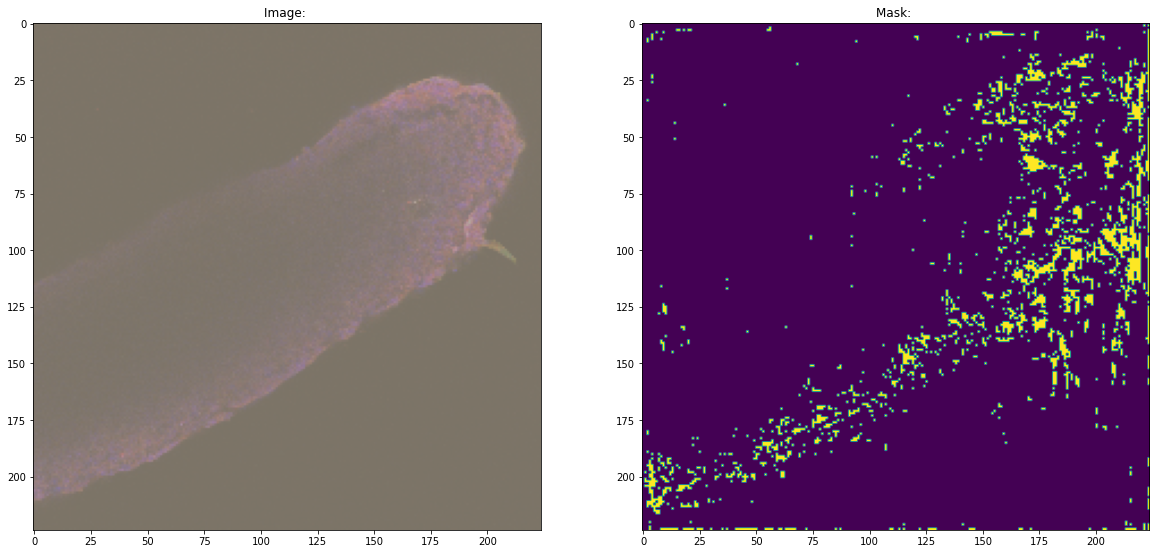

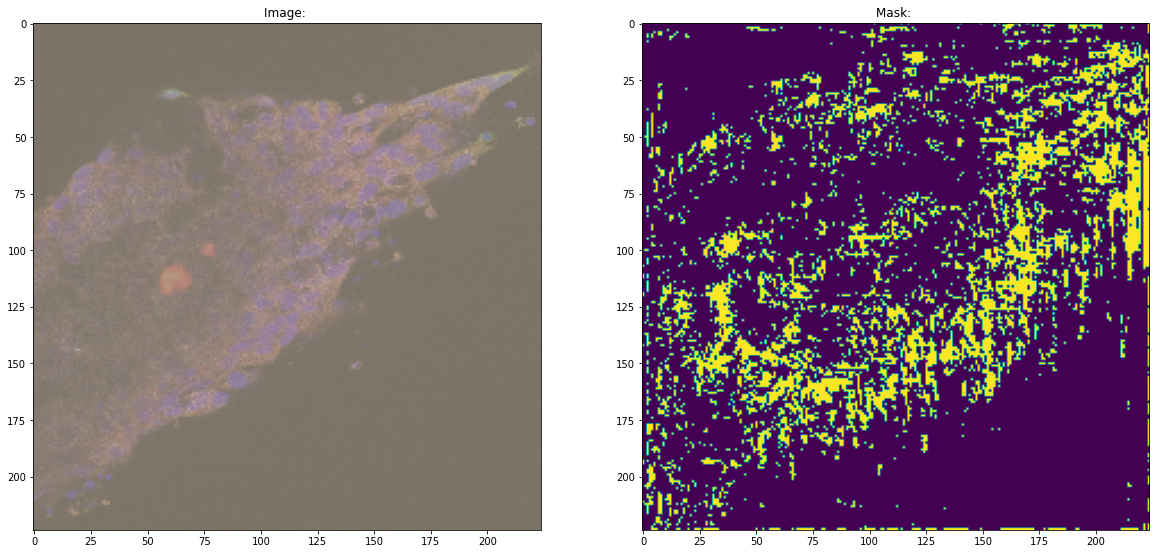

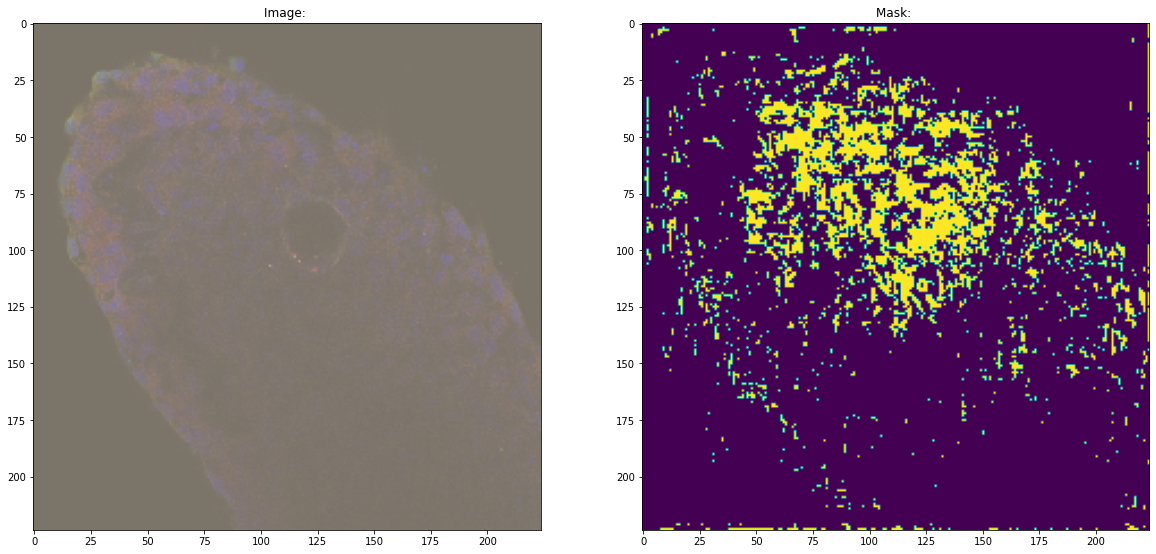

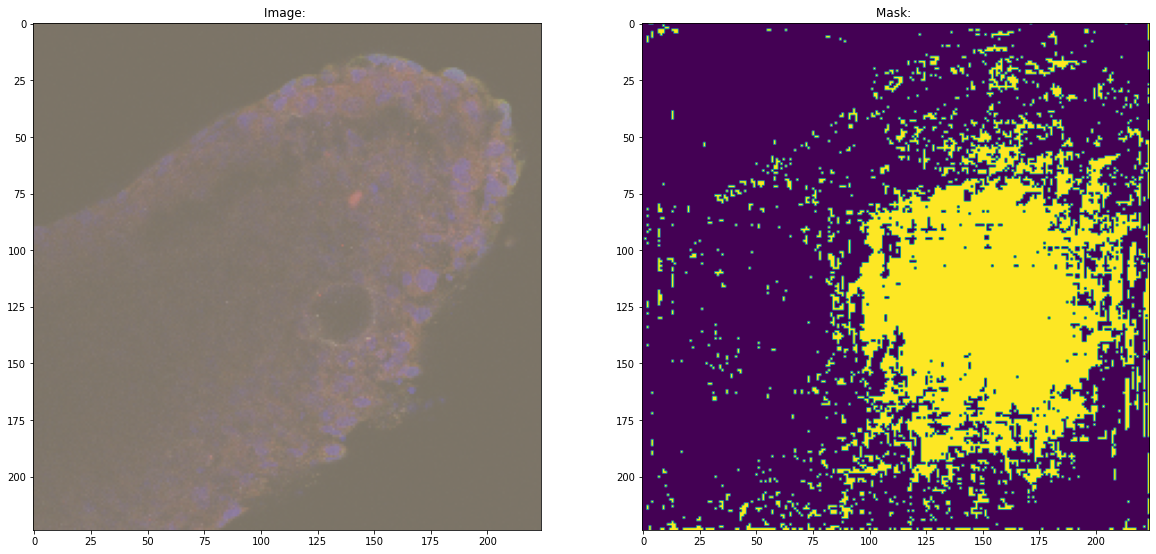

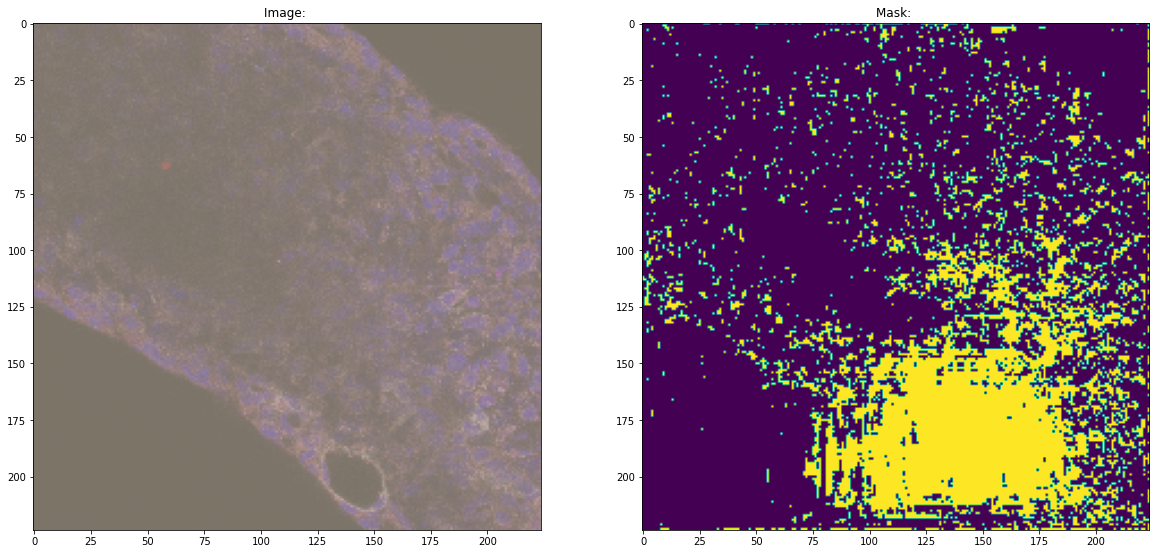

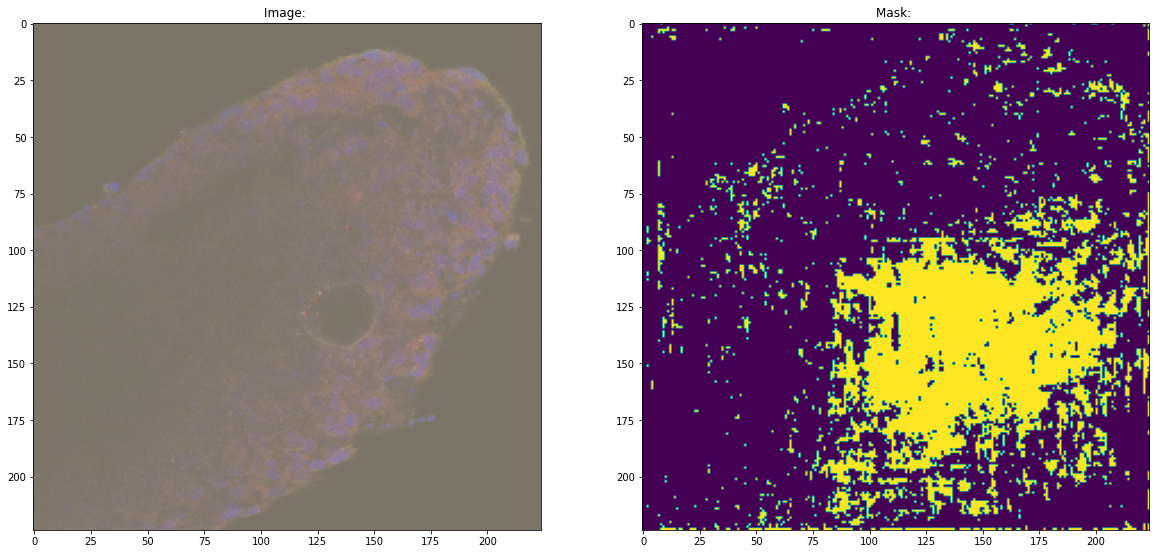

<IPython.core.display.Javascript object>

In [78]:
threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")

    show_examples(name="", image=image, mask=mask)

    if i >= max_count:
        break

In [79]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

NameError: name 'is_fp16_used' is not defined

<IPython.core.display.Javascript object>

In [ ]:
from catalyst.utils import tracing

if is_fp16_used:
    model = tracing.load_traced_model(
        f"{logdir}/trace/traced-forward-opt_O1.pth", 
        device="cuda", 
        opt_level="O1"
    )
else:
    model = tracing.load_traced_model(
        f"{logdir}/trace/traced-forward.pth", 
        device="cpu"
    )

In [ ]:
model_input = batch["image"].to("cuda" if is_fp16_used else "cpu")
model(model_input)